# HoneyBee Workshop Part 4: Multimodal Data Integration and t-SNE Visualization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lab-rasool/HoneyBee/blob/main/examples/mayo/04_data_and_multimodality.ipynb)

This notebook demonstrates how to load multimodal TCGA data from HuggingFace and create comprehensive t-SNE visualizations for individual modalities and integrated multimodal representations.

## 📋 Colab Requirements and Setup

**For Google Colab Users:**
- **Runtime**: GPU recommended (T4 or better) for faster embedding processing
- **RAM**: High-RAM runtime strongly recommended for multimodal analysis
- **Storage**: ~5GB in Google Drive for cached embeddings
- **Time**: Initial setup takes ~5 minutes; full processing ~30-45 minutes (or just 2 minutes with pre-generated embeddings!)

**What this notebook does:**
1. Loads pre-computed multimodal TCGA embeddings from HuggingFace (or downloads pre-generated ones)
2. Creates patient-level aggregations for WSI and radiology data
3. Generates t-SNE visualizations for individual modalities
4. Implements multiple multimodal fusion strategies (concatenation, mean pooling, Kronecker product)
5. Saves embeddings to Google Drive for use in downstream analyses

**🎁 NEW: Pre-generated Embeddings Option**
- Skip the 30-45 minute processing time by downloading pre-generated embeddings
- All patient-level aggregations already computed
- Identical results to running the full pipeline
- Recommended for Colab users to avoid RAM/storage issues

**Note**: This notebook uses pre-computed embeddings to avoid the computational cost of generating them from scratch.

In [4]:
# Colab Setup Cell - Run this first!
import os
import sys

# Check if we're running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
except:
    IN_COLAB = False
    print("💻 Running locally")

if IN_COLAB:
    # Install required system dependencies
    print("\n📦 Installing system dependencies...")
    !apt-get update && apt-get install -y openslide-tools tesseract-ocr
    
    # Download NLTK data (for clinical processing if needed)
    import nltk
    nltk.download('punkt', quiet=True)
    
    # Clone HoneyBee repository if not already present
    if not os.path.exists('/content/HoneyBee'):
        print("\n📥 Cloning HoneyBee repository...")
        !git clone https://github.com/lab-rasool/HoneyBee.git /content/HoneyBee
    
    # Add HoneyBee to Python path
    sys.path.insert(0, '/content/HoneyBee')
    
    # Install Python dependencies
    print("\n📦 Installing Python dependencies...")
    !curl -LsSf https://astral.sh/uv/install.sh | sh
    !uv pip install -r /content/HoneyBee/requirements.txt
    
    # Additional packages for this notebook
    !uv pip install datasets accelerate GPUtil psutil
    
    # Create necessary directories
    os.makedirs('/content/outputs', exist_ok=True)
    os.makedirs('/content/temp', exist_ok=True)
    
    print("\n✅ Colab setup complete!")
    print("\n💡 Next: Run the Google Drive mounting cell to set up persistent storage")
    
    # Check GPU availability
    import torch
    if torch.cuda.is_available():
        gpu_info = torch.cuda.get_device_name(0)
        print(f"\n🚀 GPU available: {gpu_info}")
        print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    else:
        print("\n⚠️ No GPU detected. This notebook will run slower without GPU acceleration.")
        print("   Consider changing runtime type to GPU: Runtime > Change runtime type > GPU")
else:
    # Local setup - add project to path
    from pathlib import Path
    project_root = Path().absolute().parent.parent
    sys.path.insert(0, str(project_root))
    print(f"Added to Python path: {project_root}")

# Import common libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Memory monitoring function for Colab
def print_memory_usage():
    """Print current memory usage statistics"""
    try:
        import psutil
        import torch
        
        # RAM usage
        ram = psutil.virtual_memory()
        print(f"  RAM: {ram.used / (1024**3):.1f}GB / {ram.total / (1024**3):.1f}GB ({ram.percent:.1f}%)")
        
        # GPU memory if available
        if torch.cuda.is_available():
            gpu_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
            gpu_used = torch.cuda.memory_allocated(0) / (1024**3)
            gpu_percent = (gpu_used / gpu_mem) * 100
            print(f"  GPU: {gpu_used:.1f}GB / {gpu_mem:.1f}GB ({gpu_percent:.1f}%)")
    except:
        pass

💻 Running locally
Added to Python path: /mnt/f/Projects/HoneyBee


In [5]:
# Google Drive Setup (Colab Only) - For persistent storage
if IN_COLAB:
    from google.colab import drive
    import shutil
    
    print("📁 Mounting Google Drive for persistent storage...")
    drive.mount('/content/drive')
    
    # Create a dedicated directory for HoneyBee data in Google Drive
    DRIVE_DATA_DIR = '/content/drive/MyDrive/HoneyBee_Data'
    os.makedirs(DRIVE_DATA_DIR, exist_ok=True)
    
    # Create subdirectories
    DRIVE_EMBEDDINGS_DIR = os.path.join(DRIVE_DATA_DIR, 'embeddings')
    DRIVE_CACHE_DIR = os.path.join(DRIVE_DATA_DIR, 'cache')
    DRIVE_OUTPUTS_DIR = os.path.join(DRIVE_DATA_DIR, 'outputs')
    
    for dir_path in [DRIVE_EMBEDDINGS_DIR, DRIVE_CACHE_DIR, DRIVE_OUTPUTS_DIR]:
        os.makedirs(dir_path, exist_ok=True)
    
    print(f"\n✅ Google Drive mounted successfully!")
    print(f"📂 Data directory: {DRIVE_DATA_DIR}")
    print(f"   • Embeddings: {DRIVE_EMBEDDINGS_DIR}")
    print(f"   • Cache: {DRIVE_CACHE_DIR}")
    print(f"   • Outputs: {DRIVE_OUTPUTS_DIR}")
    
    # Check available space
    stat = shutil.disk_usage(DRIVE_DATA_DIR)
    print(f"\n💾 Available space in Drive: {stat.free / (1024**3):.1f} GB")
    
    # Set environment variable for HuggingFace cache
    os.environ['HF_HOME'] = DRIVE_CACHE_DIR
    os.environ['TRANSFORMERS_CACHE'] = os.path.join(DRIVE_CACHE_DIR, 'transformers')
    os.environ['HF_DATASETS_CACHE'] = os.path.join(DRIVE_CACHE_DIR, 'datasets')
    
    print("\n🔧 HuggingFace cache set to Google Drive for persistence")
else:
    print("📁 Using local file system")
    DRIVE_DATA_DIR = './HoneyBee_Data'
    DRIVE_EMBEDDINGS_DIR = os.path.join(DRIVE_DATA_DIR, 'embeddings')
    DRIVE_CACHE_DIR = os.path.join(DRIVE_DATA_DIR, 'cache')
    DRIVE_OUTPUTS_DIR = os.path.join(DRIVE_DATA_DIR, 'outputs')
    
    for dir_path in [DRIVE_DATA_DIR, DRIVE_EMBEDDINGS_DIR, DRIVE_CACHE_DIR, DRIVE_OUTPUTS_DIR]:
        os.makedirs(dir_path, exist_ok=True)

📁 Using local file system


## 🎁 Option to Download Pre-generated Embeddings (Recommended for Colab)

To save time and avoid memory issues, you can download pre-generated embeddings that have already been computed for all patients. This is especially recommended for Google Colab users.

**Pre-generated files included:**
- ✅ Patient-level embeddings for all 5 modalities
- ✅ Patient-modality mapping  
- ✅ Multimodal fusion results (concatenation, mean pooling, Kronecker product)
- ✅ Original sample-level data for WSI and radiology

**Benefits of using pre-generated embeddings:**
- ⏱️ Saves 30-45 minutes of processing time
- 💾 Avoids potential RAM/storage issues
- 🔄 Identical results to running the full pipeline
- 📊 All embeddings are patient-level aggregated where needed

**How to use:**
1. The notebook author will provide a Google Drive link to a zip file containing all embeddings
2. Update the `EMBEDDINGS_ZIP_URL` variable in the cell below with your link
3. The notebook will automatically download and extract the embeddings
4. If files already exist in your cache, the download will be skipped

In [ ]:
# Option to download pre-generated embeddings (recommended for Colab)
DOWNLOAD_PREGENERATED = True  # Set to True to download, False to generate from scratch

if DOWNLOAD_PREGENERATED:
    print("=" * 60)
    print("📥 DOWNLOADING PRE-GENERATED EMBEDDINGS")
    print("=" * 60)
    
    import os
    import shutil
    import zipfile
    from pathlib import Path
    
    # Create cache directory
    if 'IN_COLAB' in globals() and IN_COLAB:
        cache_dir = Path(DRIVE_EMBEDDINGS_DIR) / "patient_level"
    else:
        cache_dir = Path("embedding_cache")
    
    cache_dir.mkdir(exist_ok=True, parents=True)
    print(f"\n📁 Cache directory: {cache_dir}")
    
    # Check if embeddings already exist
    required_files = [
        "clinical_embeddings.npy", "clinical_metadata.pkl",
        "pathology_embeddings.npy", "pathology_metadata.pkl",
        "wsi_embeddings.npy", "wsi_metadata.pkl",
        "molecular_embeddings.npy", "molecular_metadata.pkl",
        "radiology_embeddings.npy", "radiology_metadata.pkl",
        "patient_modality_map.pkl", "multimodal_results.pkl"
    ]
    
    all_files_exist = all((cache_dir / f).exists() for f in required_files)
    
    if all_files_exist:
        print("\n✅ Pre-generated embeddings already exist in cache!")
        print("   Skipping download...")
    else:
        # Download zip file from Google Drive
        print("\n📥 Downloading pre-generated embeddings zip file...")
        
        # Google Drive link for the embeddings zip file
        EMBEDDINGS_ZIP_URL = "https://drive.google.com/file/d/1TvZ_JoM1bEENk7W8vvnrtYTDFiNRfiH8/view?usp=drive_link"
        
        try:
            # Import gdown if in Colab
            if 'IN_COLAB' in globals() and IN_COLAB:
                import gdown
                
                # Extract file ID from URL
                if "drive.google.com" in EMBEDDINGS_ZIP_URL:
                    if "/file/d/" in EMBEDDINGS_ZIP_URL:
                        file_id = EMBEDDINGS_ZIP_URL.split("/file/d/")[1].split("/")[0]
                    elif "id=" in EMBEDDINGS_ZIP_URL:
                        file_id = EMBEDDINGS_ZIP_URL.split("id=")[1].split("&")[0]
                    else:
                        file_id = EMBEDDINGS_ZIP_URL
                    
                    download_url = f"https://drive.google.com/uc?id={file_id}"
                else:
                    download_url = EMBEDDINGS_ZIP_URL
                
                zip_path = cache_dir / "embeddings.zip"
                print(f"  Downloading to: {zip_path}")
                print(f"  File ID: {file_id}")
                gdown.download(download_url, str(zip_path), quiet=False)
            else:
                # For non-Colab environments, use wget or provide instructions
                print("\n📥 For non-Colab environments:")
                print(f"   Please download the embeddings zip file manually from:")
                print(f"   {EMBEDDINGS_ZIP_URL}")
                print(f"   And place it at: {cache_dir}/embeddings.zip")
                
                zip_path = cache_dir / "embeddings.zip"
                if not zip_path.exists():
                    raise FileNotFoundError("Please download the embeddings zip file first")
            
            # Extract zip file with proper handling of directory structure
            print("\n📦 Extracting embeddings...")
            
            # Create a temporary directory for extraction
            temp_dir = cache_dir / "temp_extract"
            temp_dir.mkdir(exist_ok=True)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # List contents to understand structure
                print("  Checking zip file structure...")
                file_list = zip_ref.namelist()
                
                # Extract everything to temp directory first
                zip_ref.extractall(temp_dir)
            
            # Find where the actual embedding files are located
            embedding_root = None
            for root, dirs, files in os.walk(temp_dir):
                # Check if this directory contains our embedding files
                if any(f in files for f in ["clinical_embeddings.npy", "pathology_embeddings.npy"]):
                    embedding_root = Path(root)
                    print(f"  Found embeddings in: {embedding_root.relative_to(temp_dir)}")
                    break
            
            if embedding_root is None:
                # Files might be directly in temp_dir
                if (temp_dir / "clinical_embeddings.npy").exists():
                    embedding_root = temp_dir
                else:
                    raise ValueError("Could not find embedding files in the zip archive")
            
            # Move all files from embedding_root to cache_dir
            print("  Moving files to cache directory...")
            for file_path in embedding_root.glob("*"):
                if file_path.is_file():
                    dest = cache_dir / file_path.name
                    shutil.move(str(file_path), str(dest))
            
            # Clean up temp directory
            shutil.rmtree(temp_dir)
            print("✅ Extraction complete!")
            
            # Remove zip file to save space
            if zip_path.exists():
                os.remove(zip_path)
                print("🗑️ Removed zip file to save space")
            
            # Verify extraction
            missing_files = [f for f in required_files if not (cache_dir / f).exists()]
            if missing_files:
                print(f"\n⚠️ Warning: Some files are missing after extraction: {missing_files}")
            
        except Exception as e:
            print(f"\n❌ Error downloading/extracting embeddings: {str(e)}")
            print("⚠️ Falling back to generating embeddings from scratch...")
            DOWNLOAD_PREGENERATED = False
            SKIP_GENERATION = False
    
    # Load the pre-generated embeddings if download was successful
    if DOWNLOAD_PREGENERATED:
        print("\n🔄 Loading pre-generated embeddings...")
        import pickle
        
        # Load embeddings and metadata
        try:
            # Clinical
            clinical_embeddings = np.load(cache_dir / "clinical_embeddings.npy")
            with open(cache_dir / "clinical_metadata.pkl", 'rb') as f:
                clinical_metadata = pickle.load(f)
            print(f"  ✓ Clinical: {clinical_embeddings.shape}")
            
            # Pathology
            pathology_embeddings = np.load(cache_dir / "pathology_embeddings.npy")
            with open(cache_dir / "pathology_metadata.pkl", 'rb') as f:
                pathology_metadata = pickle.load(f)
            print(f"  ✓ Pathology: {pathology_embeddings.shape}")
            
            # WSI (patient-level aggregated)
            wsi_embeddings = np.load(cache_dir / "wsi_embeddings.npy")
            with open(cache_dir / "wsi_metadata.pkl", 'rb') as f:
                wsi_metadata = pickle.load(f)
            print(f"  ✓ WSI (patient-level): {wsi_embeddings.shape}")
            
            # Molecular
            molecular_embeddings = np.load(cache_dir / "molecular_embeddings.npy")
            with open(cache_dir / "molecular_metadata.pkl", 'rb') as f:
                molecular_metadata = pickle.load(f)
            print(f"  ✓ Molecular: {molecular_embeddings.shape}")
            
            # Radiology (patient-level aggregated)
            radiology_embeddings = np.load(cache_dir / "radiology_embeddings.npy")
            with open(cache_dir / "radiology_metadata.pkl", 'rb') as f:
                radiology_metadata = pickle.load(f)
            print(f"  ✓ Radiology (patient-level): {radiology_embeddings.shape}")
            
            # Patient mapping
            with open(cache_dir / "patient_modality_map.pkl", 'rb') as f:
                patient_modality_map = pickle.load(f)
            print(f"  ✓ Patient mapping: {len(patient_modality_map)} patients")
            
            # Multimodal results
            with open(cache_dir / "multimodal_results.pkl", 'rb') as f:
                multimodal_results = pickle.load(f)
            print(f"  ✓ Multimodal results loaded")
            
            # Original sample-level data (if available)
            if (cache_dir / "wsi_embeddings_sample_level.npy").exists():
                original_wsi_embeddings = np.load(cache_dir / "wsi_embeddings_sample_level.npy")
                with open(cache_dir / "wsi_metadata_sample_level.pkl", 'rb') as f:
                    original_wsi_metadata = pickle.load(f)
                print(f"  ✓ Original WSI (sample-level): {original_wsi_embeddings.shape}")
            
            if (cache_dir / "radiology_embeddings_sample_level.npy").exists():
                original_radiology_embeddings = np.load(cache_dir / "radiology_embeddings_sample_level.npy")
                with open(cache_dir / "radiology_metadata_sample_level.pkl", 'rb') as f:
                    original_radiology_metadata = pickle.load(f)
                print(f"  ✓ Original radiology (sample-level): {original_radiology_embeddings.shape}")
            
            print("\n✅ All embeddings loaded successfully!")
            print("🚀 You can now skip to Section 5 for visualizations!")
            
            # Set flag to skip generation steps
            SKIP_GENERATION = True
            
        except Exception as e:
            print(f"\n❌ Error loading embeddings: {str(e)}")
            print("⚠️ Falling back to generating embeddings from scratch...")
            DOWNLOAD_PREGENERATED = False
            SKIP_GENERATION = False
        
else:
    print("📊 Generating embeddings from scratch...")
    print("⚠️ This will take 30-45 minutes and requires significant RAM")
    SKIP_GENERATION = False

## 1. Setup and Imports

Configure the environment and import necessary libraries for multimodal data processing and visualization.

## 2. Load TCGA Multimodal Dataset from HuggingFace

**Note**: This section will be skipped if you use the pre-generated embeddings option above.

The Lab-Rasool/TCGA dataset contains pre-computed embeddings from multiple state-of-the-art models across different modalities:

Available Modalities:
- **Clinical Data**: Patient demographics, treatment history, and clinical notes
- **Pathology Reports**: Diagnostic pathology text reports
- **WSI (Whole Slide Images)**: Digital pathology slide embeddings
- **Molecular Data**: Genomic and transcriptomic features
- **Radiology Images**: CT/MRI scan embeddings

Available Models:
- **Clinical/Pathology**: GatorTron, MedGemma, Qwen, Llama
- **WSI**: UNI (Universal Medical Image Encoder)
- **Molecular**: SeNMo (Self-Normalizing Networks for Multi-Omics)
- **Radiology**: REMEDIS, RadImageNet

In [ ]:
# Load TCGA multimodal dataset from HuggingFace
if 'SKIP_GENERATION' not in globals() or not SKIP_GENERATION:
    print("🔄 Loading TCGA multimodal dataset...")
    print("=" * 60)

    # Check if we're in Colab
    if 'IN_COLAB' in globals() and IN_COLAB:
        print("\n🌐 Using direct parquet loading for Colab compatibility...")
        
        # Define splits for each modality
        clinical_splits = {
            'gatortron': 'Clinical Data (gatortron-base)/data-00000-of-00001.parquet',
            'medgemma': 'Clinical Data (medgemma)/data-00000-of-00001.parquet',
            'qwen': 'Clinical Data (qwen)/data-00000-of-00001.parquet',
            'llama': 'Clinical Data (llama)/data-00000-of-00001.parquet',
            'biobert': 'Clinical Data (biobert)/data-00000-of-00001.parquet'
        }
        
        pathology_splits = {
            'gatortron': 'Pathology Report (gatortron-base)/data-00000-of-00001.parquet',
            'medgemma': 'Pathology Report (medgemma)/data-00000-of-00001.parquet',
            'qwen': 'Pathology Report (qwen)/data-00000-of-00001.parquet',
            'llama': 'Pathology Report (llama)/data-00000-of-00001.parquet'
        }
        
        # Fixed paths - files are in subdirectories with the same name
        wsi_splits = {
            'uni': 'Slide Image (UNI)/Slide Image (UNI).parquet'
        }
        
        molecular_splits = {
            'senmo': 'Molecular (SeNMo)/Molecular (SeNMo).parquet'
        }
        
        radiology_splits = {
            'remedis': 'Radiology (REMEDIS)/Radiology (REMEDIS).parquet',
            'radimagenet': 'Radiology (RadImageNet)/Radiology (RadImageNet).parquet'
        }
        
        # Load datasets using direct parquet approach
        try:
            print("\n📥 Loading clinical data (GatorTron)...")
            clinical_gatortron = pd.read_parquet("hf://datasets/Lab-Rasool/TCGA/" + clinical_splits["gatortron"])
            print(f"✅ Clinical data loaded: {len(clinical_gatortron)} samples")
        except Exception as e:
            print(f"❌ Failed to load clinical data: {str(e)[:200]}...")
            clinical_gatortron = None
        
        try:
            print("\n📥 Loading pathology data (GatorTron)...")
            pathology_gatortron = pd.read_parquet("hf://datasets/Lab-Rasool/TCGA/" + pathology_splits["gatortron"])
            print(f"✅ Pathology data loaded: {len(pathology_gatortron)} samples")
        except Exception as e:
            print(f"❌ Failed to load pathology data: {str(e)[:200]}...")
            pathology_gatortron = None
        
        try:
            print("\n📥 Loading WSI data (UNI)...")
            wsi_dataset = pd.read_parquet("hf://datasets/Lab-Rasool/TCGA/" + wsi_splits["uni"])
            print(f"✅ WSI data loaded: {len(wsi_dataset)} samples")
        except Exception as e:
            print(f"❌ Failed to load WSI data: {str(e)[:200]}...")
            wsi_dataset = None
        
        try:
            print("\n📥 Loading molecular data (SeNMo)...")
            molecular_dataset = pd.read_parquet("hf://datasets/Lab-Rasool/TCGA/" + molecular_splits["senmo"])
            print(f"✅ Molecular data loaded: {len(molecular_dataset)} samples")
        except Exception as e:
            print(f"❌ Failed to load molecular data: {str(e)[:200]}...")
            molecular_dataset = None
        
        try:
            print("\n📥 Loading radiology data (RadImageNet)...")
            radiology_radimagenet = pd.read_parquet("hf://datasets/Lab-Rasool/TCGA/" + radiology_splits["radimagenet"])
            print(f"✅ Radiology data loaded: {len(radiology_radimagenet)} samples")
        except Exception as e:
            print(f"❌ Failed to load radiology data: {str(e)[:200]}...")
            radiology_radimagenet = None
        
        # Assign to standard variable names for compatibility
        clinical_dataset = clinical_gatortron
        pathology_dataset = pathology_gatortron
        radiology_dataset = radiology_radimagenet
        
    else:
        # Standard loading approach for non-Colab environments
        print("\n💻 Using standard load_dataset approach...")
        
        # Import datasets library here if not in Colab
        from datasets import load_dataset
        
        try:
            # Clinical data embeddings (5 models available)
            clinical_gatortron = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
            clinical_medgemma = load_dataset("Lab-Rasool/TCGA", "clinical", split="medgemma")
            clinical_qwen = load_dataset("Lab-Rasool/TCGA", "clinical", split="qwen")
            clinical_llama = load_dataset("Lab-Rasool/TCGA", "clinical", split="llama")
            
            # Pathology report embeddings (4 models available)
            pathology_gatortron = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="gatortron")
            pathology_medgemma = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="medgemma")
            pathology_qwen = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="qwen")
            pathology_llama = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="llama")
            
            # Whole slide image embeddings
            wsi_dataset = load_dataset("Lab-Rasool/TCGA", "wsi", split="uni")
            
            # Molecular data embeddings
            molecular_dataset = load_dataset("Lab-Rasool/TCGA", "molecular", split="senmo")
            
            # Radiology embeddings (2 models available)
            radiology_remedis = load_dataset("Lab-Rasool/TCGA", "radiology", split="remedis")
            radiology_radimagenet = load_dataset("Lab-Rasool/TCGA", "radiology", split="radimagenet")
            
            # Assign to standard variable names
            clinical_dataset = clinical_gatortron
            pathology_dataset = pathology_gatortron
            radiology_dataset = radiology_radimagenet
            
            print("✅ All datasets loaded successfully!")
            
        except Exception as e:
            print(f"❌ Error loading datasets: {str(e)[:200]}...")
            clinical_dataset = None
            pathology_dataset = None
            wsi_dataset = None
            molecular_dataset = None
            radiology_dataset = None

    print("\n" + "=" * 60)

    # Count successfully loaded datasets
    datasets_loaded = sum([
        clinical_dataset is not None,
        pathology_dataset is not None,
        wsi_dataset is not None,
        molecular_dataset is not None,
        radiology_dataset is not None
    ])

    print(f"\n📊 Successfully loaded {datasets_loaded}/5 modalities")

    if datasets_loaded == 0 and 'IN_COLAB' in globals() and IN_COLAB:
        print("\n⚠️ AUTHENTICATION REQUIRED")
        print("=" * 60)
        print("\nThe dataset requires authentication. Please run:")
        print("\n```python")
        print("from huggingface_hub import login")
        print("login()")
        print("```")
        print("\nThen re-run this cell to load the data.")
else:
    print("✅ Using pre-generated embeddings - skipping dataset loading from HuggingFace")

## 3. Data Extraction and Processing

**Note**: This section will be skipped if you use the pre-generated embeddings option.

Extract embeddings and metadata from the HuggingFace datasets, handling different data formats and structures.

In [ ]:
def extract_embeddings_and_metadata(dataset, modality_name):
    """
    Extract embeddings and metadata from a HuggingFace dataset or DataFrame.
    Handles different embedding formats and shapes across modalities.
    Enhanced to handle direct parquet loading results.
    """
    embeddings = []
    metadata = []
    
    # Handle pandas DataFrame from direct parquet loading
    if isinstance(dataset, pd.DataFrame):
        print(f"\n📊 Processing DataFrame for {modality_name}...")
        print(f"  Shape: {dataset.shape}")
        all_columns = list(dataset.columns)
        print(f"  Columns: {all_columns[:10]}...")
        
        # Debug: print all columns to see what's available
        if len(all_columns) > 10:
            print(f"  ... and {len(all_columns) - 10} more columns")
        
        # Look for embedding column based on modality
        embedding_col = None
        
        # Molecular data uses 'Embeddings' column
        if modality_name == 'molecular' and 'Embeddings' in all_columns:
            embedding_col = 'Embeddings'
        # All other modalities use 'embedding' column (stored as bytes)
        elif 'embedding' in all_columns:
            embedding_col = 'embedding'
        
        if embedding_col:
            print(f"  Found embedding column: {embedding_col}")
            
            # Check the data type of the first embedding
            sample_embedding = dataset.iloc[0][embedding_col]
            print(f"  Sample embedding type: {type(sample_embedding)}")
            
            # For radiology, we need to check embedding sizes
            target_size = None
            if modality_name == 'radiology':
                print("  Checking radiology embedding sizes...")
                embedding_sizes = {}
                for i in range(min(100, len(dataset))):
                    emb_data = dataset.iloc[i][embedding_col]
                    if isinstance(emb_data, bytes):
                        size = len(np.frombuffer(emb_data, dtype=np.float32))
                        embedding_sizes[size] = embedding_sizes.get(size, 0) + 1
                print(f"  Embedding size distribution: {embedding_sizes}")
                # Use only the most common size (likely 1000 for RadImageNet)
                target_size = max(embedding_sizes, key=embedding_sizes.get)
                print(f"  Using embeddings of size: {target_size}")
            
            # Process each row
            for idx, row in dataset.iterrows():
                if idx >= 10000:  # Limit for memory
                    break
                    
                if idx % 1000 == 0 and idx > 0:
                    print(f"  Processing row {idx}...")
                
                # Extract embedding
                emb_data = row[embedding_col]
                
                # Handle different embedding formats
                if isinstance(emb_data, bytes):
                    # Binary format - decode as float32
                    embedding = np.frombuffer(emb_data, dtype=np.float32)
                elif isinstance(emb_data, (list, np.ndarray)):
                    embedding = np.array(emb_data, dtype=np.float32)
                else:
                    continue
                
                # For radiology, skip embeddings that don't match target size
                if modality_name == 'radiology' and target_size is not None:
                    if len(embedding) != target_size:
                        continue
                
                # Handle nested arrays (like in radiology data)
                while embedding.ndim > 1 and embedding.shape[0] == 1:
                    embedding = embedding[0]
                
                # For WSI data, check if we need to reshape based on embedding_shape
                if modality_name == 'wsi' and 'embedding_shape' in row:
                    shape = row['embedding_shape']
                    if isinstance(shape, (list, np.ndarray)) and len(shape) == 2:
                        # WSI embeddings are (21, 1024) - average over patches
                        try:
                            embedding = embedding.reshape(shape)
                            embedding = np.mean(embedding, axis=0)
                        except:
                            pass  # If reshape fails, keep original shape
                
                # Ensure embedding is 1D
                if len(embedding.shape) > 1:
                    embedding = embedding.flatten()
                
                embeddings.append(embedding)
                
                # Extract metadata
                meta = row.to_dict()
                meta['modality'] = modality_name
                # Remove embedding and shape columns from metadata to save memory
                if embedding_col in meta:
                    del meta[embedding_col]
                if 'embedding_shape' in meta:
                    del meta['embedding_shape']
                metadata.append(meta)
            
            # Convert to array
            if embeddings:
                embeddings = np.array(embeddings)
            else:
                embeddings = None
                
            metadata_df = pd.DataFrame(metadata) if metadata else None
            
            print(f"  ✓ Extracted {len(embeddings) if embeddings is not None else 0} embeddings")
            if embeddings is not None:
                print(f"  ✓ Embedding shape: {embeddings.shape}")
            
            return embeddings, metadata_df
        else:
            print(f"  ❌ No embedding column found")
            print(f"  Available columns: {all_columns}")
            return None, dataset
    
    # Original HuggingFace dataset processing (for non-DataFrame inputs)
    else:
        # Memory management for Colab
        if 'IN_COLAB' in globals() and IN_COLAB:
            batch_size = 1000
            print(f"\n📊 Processing {modality_name} in batches of {batch_size} (Colab mode)")
        else:
            batch_size = len(dataset) if hasattr(dataset, '__len__') else 1000
        
        # Check data structure
        if hasattr(dataset, '__len__') and len(dataset) > 0:
            sample_item = dataset[0]
            print(f"\n📊 Checking {modality_name} data structure:")
            print(f"  Keys available: {list(sample_item.keys())[:10]}...")
            
            # Check for embedding keys
            embedding_key = None
            if 'embedding' in sample_item:
                embedding_key = 'embedding'
            elif 'Embeddings' in sample_item:
                embedding_key = 'Embeddings'
            
            if embedding_key and sample_item[embedding_key] is not None:
                if isinstance(sample_item[embedding_key], bytes):
                    emb = np.frombuffer(sample_item[embedding_key], dtype=np.float32)
                else:
                    emb = np.array(sample_item[embedding_key], dtype=np.float32)
                    
                if 'embedding_shape' in sample_item:
                    original_shape = sample_item['embedding_shape']
                    print(f"  Original embedding shape: {original_shape}")
                    if len(original_shape) == 2:
                        emb = emb.reshape(original_shape)
                print(f"  Sample embedding shape: {emb.shape}")
        
        # Process all items
        total_items = len(dataset) if hasattr(dataset, '__len__') else 0
        for batch_start in range(0, total_items, batch_size):
            batch_end = min(batch_start + batch_size, total_items)
            if batch_start > 0:
                print(f"  Processing batch {batch_start//batch_size + 1}/{(total_items + batch_size - 1)//batch_size}...")
            
            for i in range(batch_start, batch_end):
                item = dataset[i]
                
                # Extract embedding
                embedding = None
                embedding_key = None
                
                if 'embedding' in item and item['embedding'] is not None:
                    embedding_key = 'embedding'
                    if isinstance(item['embedding'], bytes):
                        embedding = np.frombuffer(item['embedding'], dtype=np.float32)
                    else:
                        embedding = np.array(item['embedding'], dtype=np.float32)
                        
                    if 'embedding_shape' in item and len(item['embedding_shape']) == 2:
                        embedding = embedding.reshape(item['embedding_shape'])
                        
                elif 'Embeddings' in item and item['Embeddings'] is not None:
                    embedding_key = 'Embeddings'
                    embedding = np.array(item['Embeddings'], dtype=np.float32)
                
                if embedding is not None:
                    # Handle modality-specific processing
                    if modality_name == 'wsi' and len(embedding.shape) == 2:
                        embedding = np.mean(embedding, axis=0)
                    elif modality_name == 'radiology' and len(embedding.shape) == 2:
                        if embedding.shape[0] == 1:
                            embedding = embedding.squeeze(0)
                        else:
                            embedding = np.mean(embedding, axis=0)
                    elif modality_name == 'molecular':
                        if len(embedding.shape) > 1:
                            embedding = embedding.flatten()
                    elif len(embedding.shape) > 1:
                        embedding = embedding.flatten()
                    
                    if embedding.shape[0] < 100000:
                        embeddings.append(embedding)
                        
                        # Extract metadata
                        meta = {k: v for k, v in item.items() if k not in [embedding_key, 'embedding_shape']}
                        meta['modality'] = modality_name
                        meta['original_shape'] = item.get('embedding_shape', embedding.shape)
                        metadata.append(meta)
        
        # Convert to arrays
        if embeddings:
            embeddings = np.array(embeddings)
            print(f"  ✓ Final {modality_name} embeddings shape: {embeddings.shape}")
        else:
            embeddings = None
            
        metadata_df = pd.DataFrame(metadata) if metadata else None
        
        return embeddings, metadata_df

# Extract embeddings for each modality - only if not using pre-generated
if 'SKIP_GENERATION' not in globals() or not SKIP_GENERATION:
    print("🔄 Extracting embeddings and metadata...")
    print("=" * 60)

    # Process each modality
    if clinical_dataset is not None:
        clinical_embeddings, clinical_metadata = extract_embeddings_and_metadata(clinical_dataset, 'clinical')
        print(f"\n✅ Clinical embeddings: {clinical_embeddings.shape if clinical_embeddings is not None else 'None'}")
    else:
        clinical_embeddings, clinical_metadata = None, None

    if pathology_dataset is not None:
        pathology_embeddings, pathology_metadata = extract_embeddings_and_metadata(pathology_dataset, 'pathology')
        print(f"✅ Pathology embeddings: {pathology_embeddings.shape if pathology_embeddings is not None else 'None'}")
    else:
        pathology_embeddings, pathology_metadata = None, None

    if wsi_dataset is not None:
        wsi_embeddings, wsi_metadata = extract_embeddings_and_metadata(wsi_dataset, 'wsi')
        print(f"✅ WSI embeddings: {wsi_embeddings.shape if wsi_embeddings is not None else 'None'}")
    else:
        wsi_embeddings, wsi_metadata = None, None

    if molecular_dataset is not None:
        molecular_embeddings, molecular_metadata = extract_embeddings_and_metadata(molecular_dataset, 'molecular')
        print(f"✅ Molecular embeddings: {molecular_embeddings.shape if molecular_embeddings is not None else 'None'}")
    else:
        molecular_embeddings, molecular_metadata = None, None

    if radiology_dataset is not None:
        radiology_embeddings, radiology_metadata = extract_embeddings_and_metadata(radiology_dataset, 'radiology')
        print(f"✅ Radiology embeddings: {radiology_embeddings.shape if radiology_embeddings is not None else 'None'}")
    else:
        radiology_embeddings, radiology_metadata = None, None

    print("\n" + "=" * 60)

    # Memory check for Colab
    if 'IN_COLAB' in globals() and IN_COLAB:
        print("\n📊 Memory status after extraction:")
        print_memory_usage()
        
        # Clear memory if needed
        try:
            import psutil
            ram = psutil.virtual_memory()
            if ram.percent > 80:
                import gc
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                print("✅ Memory cleared")
        except:
            pass
else:
    print("✅ Using pre-generated embeddings - skipping extraction step")

## 3.5 Build Patient-Modality Mapping

To properly integrate multimodal data, we need to track which modalities are available for each patient. This mapping is crucial for:
- Identifying patients with multiple modalities
- Ensuring correct alignment across modalities
- Computing modality combination statistics

In [8]:
# Build comprehensive patient-modality mapping
print("🔍 Building patient-modality mapping...")
print("=" * 60)

patient_modality_map = {}

# Add clinical data to mapping
if clinical_embeddings is not None and clinical_metadata is not None:
    print("\n📋 Mapping clinical data...")
    unique_patients = set()
    for i in range(len(clinical_metadata)):
        patient_id = clinical_metadata.iloc[i].get('case_submitter_id', None)
        if patient_id:
            unique_patients.add(patient_id)
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            patient_modality_map[patient_id]['clinical'] = i
            patient_modality_map[patient_id]['project_id'] = clinical_metadata.iloc[i].get('project_id', 'Unknown')
            patient_modality_map[patient_id]['gender'] = clinical_metadata.iloc[i].get('sex', clinical_metadata.iloc[i].get('gender', 'Unknown'))
            patient_modality_map[patient_id]['age_at_index'] = clinical_metadata.iloc[i].get('age_at_index', None)
    print(f"  ✓ Mapped {len(unique_patients)} unique patients from {len(clinical_metadata)} samples")

# Add pathology data to mapping
if pathology_embeddings is not None and pathology_metadata is not None:
    print("\n🔬 Mapping pathology data...")
    unique_patients = set()
    for i in range(len(pathology_metadata)):
        patient_id = pathology_metadata.iloc[i].get('PatientID', None)
        if patient_id:
            unique_patients.add(patient_id)
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            if 'pathology' not in patient_modality_map[patient_id]:
                patient_modality_map[patient_id]['pathology'] = []
            patient_modality_map[patient_id]['pathology'].append(i)
    # Store only the first index for compatibility
    for patient_id in patient_modality_map:
        if 'pathology' in patient_modality_map[patient_id] and isinstance(patient_modality_map[patient_id]['pathology'], list):
            patient_modality_map[patient_id]['pathology'] = patient_modality_map[patient_id]['pathology'][0]
    print(f"  ✓ Mapped {len(unique_patients)} unique patients from {len(pathology_metadata)} samples")

# Add WSI data to mapping (if available)
if wsi_embeddings is not None and wsi_metadata is not None:
    print("\n🔬 Mapping WSI data...")
    unique_patients = set()
    patient_slide_count = {}
    for i in range(len(wsi_metadata)):
        # Try different ID fields
        patient_id = wsi_metadata.iloc[i].get('case_submitter_id', 
                    wsi_metadata.iloc[i].get('PatientID',
                    wsi_metadata.iloc[i].get('case_id', None)))
        if patient_id:
            unique_patients.add(patient_id)
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            if 'wsi' not in patient_modality_map[patient_id]:
                patient_modality_map[patient_id]['wsi'] = []
                patient_slide_count[patient_id] = 0
            patient_modality_map[patient_id]['wsi'].append(i)
            patient_slide_count[patient_id] += 1
    
    # Calculate statistics
    if patient_slide_count:
        avg_slides = np.mean(list(patient_slide_count.values()))
        max_slides = max(patient_slide_count.values())
        print(f"  ✓ Mapped {len(unique_patients)} unique patients from {len(wsi_metadata)} slides")
        print(f"     Average slides per patient: {avg_slides:.1f}")
        print(f"     Max slides per patient: {max_slides}")
    
    # Store only the first index for compatibility
    for patient_id in patient_modality_map:
        if 'wsi' in patient_modality_map[patient_id] and isinstance(patient_modality_map[patient_id]['wsi'], list):
            patient_modality_map[patient_id]['wsi_indices'] = patient_modality_map[patient_id]['wsi']  # Keep all indices
            patient_modality_map[patient_id]['wsi'] = patient_modality_map[patient_id]['wsi'][0]  # Use first for compatibility

# Add molecular data to mapping (if available)
if molecular_embeddings is not None and molecular_metadata is not None:
    print("\n🧬 Mapping molecular data...")
    unique_patients = set()
    for i in range(len(molecular_metadata)):
        patient_id = molecular_metadata.iloc[i].get('PatientID', 
                    molecular_metadata.iloc[i].get('case_submitter_id', None))
        if patient_id:
            unique_patients.add(patient_id)
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            patient_modality_map[patient_id]['molecular'] = i
    print(f"  ✓ Mapped {len(unique_patients)} unique patients from {len(molecular_metadata)} samples")

# Add radiology data to mapping (if available)
if radiology_embeddings is not None and radiology_metadata is not None:
    print("\n🏥 Mapping radiology data...")
    unique_patients = set()
    patient_scan_count = {}
    for i in range(len(radiology_metadata)):
        patient_id = radiology_metadata.iloc[i].get('PatientID',
                    radiology_metadata.iloc[i].get('case_submitter_id', None))
        if patient_id:
            unique_patients.add(patient_id)
            if patient_id not in patient_modality_map:
                patient_modality_map[patient_id] = {}
            if 'radiology' not in patient_modality_map[patient_id]:
                patient_modality_map[patient_id]['radiology'] = []
                patient_scan_count[patient_id] = 0
            patient_modality_map[patient_id]['radiology'].append(i)
            patient_scan_count[patient_id] += 1
    
    # Calculate statistics
    if patient_scan_count:
        avg_scans = np.mean(list(patient_scan_count.values()))
        max_scans = max(patient_scan_count.values())
        print(f"  ✓ Mapped {len(unique_patients)} unique patients from {len(radiology_metadata)} slices/scans")
        print(f"     Average items per patient: {avg_scans:.1f}")
        print(f"     Max items per patient: {max_scans}")
    
    # Store only the first index for compatibility
    for patient_id in patient_modality_map:
        if 'radiology' in patient_modality_map[patient_id] and isinstance(patient_modality_map[patient_id]['radiology'], list):
            patient_modality_map[patient_id]['radiology_indices'] = patient_modality_map[patient_id]['radiology']  # Keep all indices
            patient_modality_map[patient_id]['radiology'] = patient_modality_map[patient_id]['radiology'][0]  # Use first for compatibility

# Print comprehensive statistics
print("\n" + "=" * 60)
print("📊 PATIENT-MODALITY STATISTICS")
print("=" * 60)
print(f"Total unique patients: {len(patient_modality_map)}")

# Count modality combinations
modality_counts = {}
for patient_id, patient_data in patient_modality_map.items():
    # Get available modalities (excluding metadata fields)
    modalities = [k for k in patient_data.keys() if k in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']]
    n_modalities = len(modalities)
    
    if n_modalities not in modality_counts:
        modality_counts[n_modalities] = 0
    modality_counts[n_modalities] += 1

print("\n📈 Patients by number of modalities:")
for n_mods in sorted(modality_counts.keys()):
    percentage = (modality_counts[n_mods] / len(patient_modality_map)) * 100
    print(f"  {n_mods} modalities: {modality_counts[n_mods]:,} patients ({percentage:.1f}%)")

# Get modality combination statistics
modality_combos = {}
for patient_id, patient_data in patient_modality_map.items():
    modalities = sorted([k for k in patient_data.keys() if k in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']])
    combo = '+'.join(modalities)
    if combo not in modality_combos:
        modality_combos[combo] = 0
    modality_combos[combo] += 1

print("\n🔝 Top 10 modality combinations:")
for combo, count in sorted(modality_combos.items(), key=lambda x: x[1], reverse=True)[:10]:
    percentage = (count / len(patient_modality_map)) * 100
    print(f"  {combo}: {count:,} patients ({percentage:.1f}%)")

🔍 Building patient-modality mapping...

📋 Mapping clinical data...
  ✓ Mapped 10771 unique patients from 10771 samples

🔬 Mapping pathology data...
  ✓ Mapped 10771 unique patients from 10857 samples

🔬 Mapping WSI data...
  ✓ Mapped 8060 unique patients from 22643 slides
     Average slides per patient: 2.8
     Max slides per patient: 16

🧬 Mapping molecular data...
  ✓ Mapped 10938 unique patients from 13804 samples

🏥 Mapping radiology data...
  ✓ Mapped 1149 unique patients from 11229 slices/scans
     Average items per patient: 9.8
     Max items per patient: 93

📊 PATIENT-MODALITY STATISTICS
Total unique patients: 11145

📈 Patients by number of modalities:
  1 modalities: 355 patients (3.2%)
  2 modalities: 26 patients (0.2%)
  3 modalities: 2,723 patients (24.4%)
  4 modalities: 7,092 patients (63.6%)
  5 modalities: 949 patients (8.5%)

🔝 Top 10 modality combinations:
  clinical+molecular+pathology+wsi: 6,937 patients (62.2%)
  clinical+molecular+pathology: 2,702 patients (24.

## 3.6 Patient-Level Aggregation for Multi-Sample Modalities 🔄

For modalities like WSI and radiology, each patient may have:
- **WSI**: Multiple slides, each with multiple patches (21 patches per slide in this dataset)
- **Radiology**: Multiple scans, each with multiple slices

We need to aggregate these to create a single embedding vector per patient per modality for proper multimodal integration.

In [9]:
def aggregate_patient_embeddings(embeddings, metadata, modality_name):
    """
    Aggregate embeddings at the patient level for modalities with multiple samples per patient.
    
    For WSI: patches -> slide -> patient
    For Radiology: slices -> scan -> patient
    """
    print(f"\n🔄 Aggregating {modality_name} embeddings at patient level...")
    
    # Check for NaN values in input
    if embeddings.ndim > 1:
        nan_count = np.isnan(embeddings).any(axis=1).sum()
    else:
        nan_count = np.isnan(embeddings).sum()
    
    if nan_count > 0:
        print(f"  ⚠️ Found {nan_count} samples with NaN values in input embeddings")
    
    # Create patient-level aggregation
    patient_embeddings = {}
    patient_metadata_dict = {}
    
    if modality_name == 'wsi':
        # For WSI, we need to handle the hierarchical structure
        print("  Processing WSI data (patches -> slides -> patients)...")
        
        for i in range(len(metadata)):
            # Skip samples with NaN embeddings
            if embeddings.ndim > 1:
                if np.isnan(embeddings[i]).any():
                    continue
            else:
                if np.isnan(embeddings[i]):
                    continue
                
            # Get patient ID - try different fields
            patient_id = metadata.iloc[i].get('case_submitter_id',
                        metadata.iloc[i].get('PatientID', 
                        metadata.iloc[i].get('case_id', None)))
            
            if patient_id:
                # Get the embedding for this sample
                embedding = embeddings[i]
                
                # WSI embeddings were already averaged over patches in extract_embeddings_and_metadata
                # So each row represents one slide
                
                if patient_id not in patient_embeddings:
                    patient_embeddings[patient_id] = []
                    patient_metadata_dict[patient_id] = {
                        'patient_id': patient_id,
                        'num_slides': 0,
                        'modality': modality_name
                    }
                
                patient_embeddings[patient_id].append(embedding)
                patient_metadata_dict[patient_id]['num_slides'] += 1
        
        # Average embeddings across slides for each patient
        print(f"  Aggregating slides for {len(patient_embeddings)} patients...")
        final_patient_embeddings = []
        final_patient_metadata = []
        
        for patient_id, slide_embeddings in patient_embeddings.items():
            # Average across all slides for this patient
            patient_embedding = np.nanmean(slide_embeddings, axis=0)
            
            # Skip if result is all NaN
            if np.isnan(patient_embedding).all():
                print(f"  ⚠️ Skipping patient {patient_id} - all NaN after aggregation")
                continue
                
            final_patient_embeddings.append(patient_embedding)
            
            patient_meta = patient_metadata_dict[patient_id]
            patient_meta['aggregation_method'] = 'mean_pooling'
            final_patient_metadata.append(patient_meta)
        
        print(f"  ✓ Aggregated {len(metadata)} slides → {len(final_patient_embeddings)} patients")
        
    elif modality_name == 'radiology':
        # For radiology, handle scan-level aggregation
        print("  Processing radiology data (slices -> scans -> patients)...")
        
        for i in range(len(metadata)):
            # Skip samples with NaN embeddings
            if embeddings.ndim > 1:
                if np.isnan(embeddings[i]).any():
                    continue
            else:
                if np.isnan(embeddings[i]):
                    continue
                
            # Get patient ID
            patient_id = metadata.iloc[i].get('PatientID',
                        metadata.iloc[i].get('case_submitter_id', None))
            
            # Get scan ID to group slices
            scan_id = metadata.iloc[i].get('SeriesInstanceUID',
                     metadata.iloc[i].get('StudyInstanceUID', None))
            
            if patient_id:
                embedding = embeddings[i]
                
                if patient_id not in patient_embeddings:
                    patient_embeddings[patient_id] = {}
                    patient_metadata_dict[patient_id] = {
                        'patient_id': patient_id,
                        'num_scans': 0,
                        'num_slices': 0,
                        'modality': modality_name
                    }
                
                # Group by scan if scan_id available
                if scan_id:
                    if scan_id not in patient_embeddings[patient_id]:
                        patient_embeddings[patient_id][scan_id] = []
                        patient_metadata_dict[patient_id]['num_scans'] += 1
                    patient_embeddings[patient_id][scan_id].append(embedding)
                else:
                    # If no scan ID, just collect all embeddings
                    if 'all_slices' not in patient_embeddings[patient_id]:
                        patient_embeddings[patient_id]['all_slices'] = []
                    patient_embeddings[patient_id]['all_slices'].append(embedding)
                
                patient_metadata_dict[patient_id]['num_slices'] += 1
        
        # Aggregate: first average within scans, then across scans
        print(f"  Aggregating scans for {len(patient_embeddings)} patients...")
        final_patient_embeddings = []
        final_patient_metadata = []
        
        for patient_id, patient_scans in patient_embeddings.items():
            scan_embeddings = []
            
            for scan_id, slices in patient_scans.items():
                # Average slices within each scan (using nanmean to handle any NaN)
                scan_embedding = np.nanmean(slices, axis=0)
                if not np.isnan(scan_embedding).all():
                    scan_embeddings.append(scan_embedding)
            
            if not scan_embeddings:
                print(f"  ⚠️ Skipping patient {patient_id} - no valid scans after aggregation")
                continue
                
            # Average across all scans for this patient
            patient_embedding = np.nanmean(scan_embeddings, axis=0)
            
            # Skip if result is all NaN
            if np.isnan(patient_embedding).all():
                print(f"  ⚠️ Skipping patient {patient_id} - all NaN after aggregation")
                continue
                
            final_patient_embeddings.append(patient_embedding)
            
            patient_meta = patient_metadata_dict[patient_id]
            patient_meta['aggregation_method'] = 'hierarchical_mean_pooling'
            final_patient_metadata.append(patient_meta)
        
        print(f"  ✓ Aggregated {len(metadata)} slices → {len(final_patient_embeddings)} patients")
        
    else:
        # For other modalities, assume one sample per patient
        print(f"  {modality_name} appears to have one sample per patient, no aggregation needed")
        return embeddings, metadata
    
    # Convert to numpy array and DataFrame
    if final_patient_embeddings:
        patient_embeddings_array = np.array(final_patient_embeddings)
        patient_metadata_df = pd.DataFrame(final_patient_metadata)
        
        # Check for NaN in final output - handle both 1D and 2D arrays
        if patient_embeddings_array.ndim > 1:
            final_nan_count = np.isnan(patient_embeddings_array).any(axis=1).sum()
        else:
            final_nan_count = np.isnan(patient_embeddings_array).sum()
            
        if final_nan_count > 0:
            print(f"  ⚠️ Warning: {final_nan_count} patients still have NaN values after aggregation")
    else:
        print(f"  ⚠️ No valid patient embeddings after aggregation")
        return None, None
    
    # Print aggregation statistics
    if modality_name == 'wsi':
        avg_slides = np.mean([m['num_slides'] for m in final_patient_metadata])
        max_slides = np.max([m['num_slides'] for m in final_patient_metadata])
        print(f"\n  📊 WSI Statistics:")
        print(f"     Average slides per patient: {avg_slides:.1f}")
        print(f"     Max slides per patient: {max_slides}")
        
    elif modality_name == 'radiology':
        avg_scans = np.mean([m['num_scans'] for m in final_patient_metadata if m['num_scans'] > 0])
        avg_slices = np.mean([m['num_slices'] for m in final_patient_metadata])
        print(f"\n  📊 Radiology Statistics:")
        print(f"     Average scans per patient: {avg_scans:.1f}")
        print(f"     Average slices per patient: {avg_slices:.1f}")
    
    return patient_embeddings_array, patient_metadata_df

# Perform patient-level aggregation for WSI and radiology
print("=" * 60)
print("🔄 PATIENT-LEVEL EMBEDDING AGGREGATION")
print("=" * 60)

# Store original embeddings before aggregation
original_wsi_embeddings = wsi_embeddings
original_wsi_metadata = wsi_metadata
original_radiology_embeddings = radiology_embeddings
original_radiology_metadata = radiology_metadata

# Aggregate WSI embeddings at patient level
if wsi_embeddings is not None and wsi_metadata is not None:
    wsi_patient_embeddings, wsi_patient_metadata = aggregate_patient_embeddings(
        wsi_embeddings, wsi_metadata, 'wsi'
    )
    if wsi_patient_embeddings is not None:
        print(f"\n✅ WSI patient-level embeddings: {wsi_patient_embeddings.shape}")
    else:
        print("\n❌ WSI patient-level aggregation failed")
        wsi_patient_embeddings, wsi_patient_metadata = None, None
else:
    wsi_patient_embeddings, wsi_patient_metadata = None, None

# Aggregate radiology embeddings at patient level
if radiology_embeddings is not None and radiology_metadata is not None:
    radiology_patient_embeddings, radiology_patient_metadata = aggregate_patient_embeddings(
        radiology_embeddings, radiology_metadata, 'radiology'
    )
    if radiology_patient_embeddings is not None:
        print(f"\n✅ Radiology patient-level embeddings: {radiology_patient_embeddings.shape}")
    else:
        print("\n❌ Radiology patient-level aggregation failed")
        radiology_patient_embeddings, radiology_patient_metadata = None, None
else:
    radiology_patient_embeddings, radiology_patient_metadata = None, None

print("\n" + "=" * 60)

🔄 PATIENT-LEVEL EMBEDDING AGGREGATION

🔄 Aggregating wsi embeddings at patient level...
  Processing WSI data (patches -> slides -> patients)...
  Aggregating slides for 8060 patients...
  ✓ Aggregated 22643 slides → 8060 patients

  📊 WSI Statistics:
     Average slides per patient: 2.8
     Max slides per patient: 16

✅ WSI patient-level embeddings: (8060, 1024)

🔄 Aggregating radiology embeddings at patient level...
  ⚠️ Found 66 samples with NaN values in input embeddings
  Processing radiology data (slices -> scans -> patients)...
  Aggregating scans for 1149 patients...
  ✓ Aggregated 11229 slices → 1149 patients

  📊 Radiology Statistics:
     Average scans per patient: 9.7
     Average slices per patient: 9.7

✅ Radiology patient-level embeddings: (1149, 1000)



## 3.7 Rebuild Patient-Modality Mapping with Aggregated Data 🗺️

Now we need to rebuild the patient-modality mapping using the patient-level embeddings for WSI and radiology, while keeping the original mappings for clinical, pathology, and molecular data.

In [10]:
# Rebuild patient-modality mapping with aggregated data
print("🔍 Rebuilding patient-modality mapping with aggregated data...")
print("=" * 60)

# Create new patient modality map
patient_modality_map_aggregated = {}

# Add clinical data (unchanged)
if clinical_embeddings is not None and clinical_metadata is not None:
    print("\n📋 Mapping clinical data...")
    for i in range(len(clinical_metadata)):
        patient_id = clinical_metadata.iloc[i].get('case_submitter_id', None)
        if patient_id:
            if patient_id not in patient_modality_map_aggregated:
                patient_modality_map_aggregated[patient_id] = {}
            patient_modality_map_aggregated[patient_id]['clinical'] = i
            patient_modality_map_aggregated[patient_id]['project_id'] = clinical_metadata.iloc[i].get('project_id', 'Unknown')
            patient_modality_map_aggregated[patient_id]['gender'] = clinical_metadata.iloc[i].get('sex', clinical_metadata.iloc[i].get('gender', 'Unknown'))
            patient_modality_map_aggregated[patient_id]['age_at_index'] = clinical_metadata.iloc[i].get('age_at_index', None)
    print(f"  ✓ Mapped {len([p for p in patient_modality_map_aggregated if 'clinical' in patient_modality_map_aggregated[p]])} patients")

# Add pathology data (unchanged)
if pathology_embeddings is not None and pathology_metadata is not None:
    print("\n🔬 Mapping pathology data...")
    mapped_count = 0
    for i in range(len(pathology_metadata)):
        patient_id = pathology_metadata.iloc[i].get('PatientID', None)
        if patient_id:
            if patient_id not in patient_modality_map_aggregated:
                patient_modality_map_aggregated[patient_id] = {}
            patient_modality_map_aggregated[patient_id]['pathology'] = i
            mapped_count += 1
    print(f"  ✓ Mapped {mapped_count} patients")

# Add aggregated WSI data
if wsi_patient_embeddings is not None and wsi_patient_metadata is not None:
    print("\n🔬 Mapping aggregated WSI data...")
    mapped_count = 0
    for i in range(len(wsi_patient_metadata)):
        patient_id = wsi_patient_metadata.iloc[i]['patient_id']
        if patient_id:
            if patient_id not in patient_modality_map_aggregated:
                patient_modality_map_aggregated[patient_id] = {}
            patient_modality_map_aggregated[patient_id]['wsi'] = i
            patient_modality_map_aggregated[patient_id]['wsi_num_slides'] = wsi_patient_metadata.iloc[i]['num_slides']
            mapped_count += 1
    print(f"  ✓ Mapped {mapped_count} patients (aggregated from slides)")

# Add molecular data (unchanged)
if molecular_embeddings is not None and molecular_metadata is not None:
    print("\n🧬 Mapping molecular data...")
    mapped_count = 0
    for i in range(len(molecular_metadata)):
        patient_id = molecular_metadata.iloc[i].get('PatientID', 
                    molecular_metadata.iloc[i].get('case_submitter_id', None))
        if patient_id:
            if patient_id not in patient_modality_map_aggregated:
                patient_modality_map_aggregated[patient_id] = {}
            patient_modality_map_aggregated[patient_id]['molecular'] = i
            mapped_count += 1
    print(f"  ✓ Mapped {mapped_count} patients")

# Add aggregated radiology data
if radiology_patient_embeddings is not None and radiology_patient_metadata is not None:
    print("\n🏥 Mapping aggregated radiology data...")
    mapped_count = 0
    for i in range(len(radiology_patient_metadata)):
        patient_id = radiology_patient_metadata.iloc[i]['patient_id']
        if patient_id:
            if patient_id not in patient_modality_map_aggregated:
                patient_modality_map_aggregated[patient_id] = {}
            patient_modality_map_aggregated[patient_id]['radiology'] = i
            patient_modality_map_aggregated[patient_id]['radiology_num_scans'] = radiology_patient_metadata.iloc[i]['num_scans']
            patient_modality_map_aggregated[patient_id]['radiology_num_slices'] = radiology_patient_metadata.iloc[i]['num_slices']
            mapped_count += 1
    print(f"  ✓ Mapped {mapped_count} patients (aggregated from scans/slices)")

# Update embeddings to use patient-level aggregated versions
wsi_embeddings = wsi_patient_embeddings
wsi_metadata = wsi_patient_metadata
radiology_embeddings = radiology_patient_embeddings
radiology_metadata = radiology_patient_metadata

# Print comprehensive statistics
print("\n" + "=" * 60)
print("📊 UPDATED PATIENT-MODALITY STATISTICS (WITH AGGREGATION)")
print("=" * 60)
print(f"Total unique patients: {len(patient_modality_map_aggregated)}")

# Count modality combinations
modality_counts = {}
for patient_id, patient_data in patient_modality_map_aggregated.items():
    # Get available modalities (excluding metadata fields)
    modalities = [k for k in patient_data.keys() if k in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']]
    n_modalities = len(modalities)
    
    if n_modalities not in modality_counts:
        modality_counts[n_modalities] = 0
    modality_counts[n_modalities] += 1

print("\n📈 Patients by number of modalities:")
for n_mods in sorted(modality_counts.keys()):
    percentage = (modality_counts[n_mods] / len(patient_modality_map_aggregated)) * 100
    print(f"  {n_mods} modalities: {modality_counts[n_mods]:,} patients ({percentage:.1f}%)")

# Get modality combination statistics
modality_combos = {}
for patient_id, patient_data in patient_modality_map_aggregated.items():
    modalities = sorted([k for k in patient_data.keys() if k in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']])
    combo = '+'.join(modalities)
    if combo not in modality_combos:
        modality_combos[combo] = 0
    modality_combos[combo] += 1

print("\n🔝 Top 10 modality combinations:")
for combo, count in sorted(modality_combos.items(), key=lambda x: x[1], reverse=True)[:10]:
    percentage = (count / len(patient_modality_map_aggregated)) * 100
    print(f"  {combo}: {count:,} patients ({percentage:.1f}%)")

# Replace the old mapping with the aggregated one
patient_modality_map = patient_modality_map_aggregated
print("\n✅ Patient-modality mapping updated with aggregated data!")

🔍 Rebuilding patient-modality mapping with aggregated data...

📋 Mapping clinical data...
  ✓ Mapped 10771 patients

🔬 Mapping pathology data...
  ✓ Mapped 10857 patients

🔬 Mapping aggregated WSI data...
  ✓ Mapped 8060 patients (aggregated from slides)

🧬 Mapping molecular data...
  ✓ Mapped 13804 patients

🏥 Mapping aggregated radiology data...
  ✓ Mapped 1149 patients (aggregated from scans/slices)

📊 UPDATED PATIENT-MODALITY STATISTICS (WITH AGGREGATION)
Total unique patients: 11145

📈 Patients by number of modalities:
  1 modalities: 355 patients (3.2%)
  2 modalities: 26 patients (0.2%)
  3 modalities: 2,723 patients (24.4%)
  4 modalities: 7,092 patients (63.6%)
  5 modalities: 949 patients (8.5%)

🔝 Top 10 modality combinations:
  clinical+molecular+pathology+wsi: 6,937 patients (62.2%)
  clinical+molecular+pathology: 2,702 patients (24.2%)
  clinical+molecular+pathology+radiology+wsi: 949 patients (8.5%)
  molecular: 180 patients (1.6%)
  clinical+molecular+pathology+radiolog

## 4. Helper Functions for t-SNE Visualization

Define comprehensive helper functions for creating publication-quality t-SNE visualizations with proper styling and TCGA-specific color schemes.

In [11]:
def create_age_groups(age):
    """Categorize age into groups"""
    if pd.isna(age) or age == 'Unknown':
        return 'Unknown'
    try:
        age_val = float(age)
        if age_val < 40:
            return '<40'
        elif age_val < 50:
            return '40-49'
        elif age_val < 60:
            return '50-59'
        elif age_val < 70:
            return '60-69'
        else:
            return '70+'
    except:
        return 'Unknown'

def get_tcga_color_scheme():
    """Get the TCGA project color scheme - updated to match create_tsne_visualizations.py"""
    return {
        # Brain cancers - blues
        'TCGA-GBM': '#4A90E2',  # Glioblastoma
        'TCGA-LGG': '#7BB3F0',  # Lower grade glioma
        
        # Kidney cancers - greens  
        'TCGA-KIRC': '#27AE60',  # Clear cell
        'TCGA-KIRP': '#52C77F',  # Papillary
        'TCGA-KICH': '#7ED99F',  # Chromophobe
        
        # Lung cancers - oranges
        'TCGA-LUAD': '#F39C12',  # Adenocarcinoma
        'TCGA-LUSC': '#FDB94E',  # Squamous cell
        
        # GI cancers - reds/pinks
        'TCGA-COAD': '#E74C3C',  # Colon
        'TCGA-READ': '#F17A72',  # Rectal
        'TCGA-STAD': '#FF9999',  # Stomach
        'TCGA-ESCA': '#FFB3B3',  # Esophageal
        
        # Liver/pancreas - purples
        'TCGA-LIHC': '#9B59B6',  # Liver
        'TCGA-PAAD': '#B983CC',  # Pancreatic
        'TCGA-CHOL': '#D7BDE2',  # Cholangiocarcinoma
        
        # Gynecological - magentas
        'TCGA-BRCA': '#E91E63',  # Breast
        'TCGA-OV': '#F06292',   # Ovarian
        'TCGA-UCEC': '#F8BBD0',  # Endometrial
        'TCGA-CESC': '#FCE4EC',  # Cervical
        'TCGA-UCS': '#FFCDD2',   # Uterine carcinosarcoma
        
        # Urological - teals
        'TCGA-BLCA': '#00BCD4',  # Bladder
        'TCGA-PRAD': '#4DD0E1',  # Prostate
        'TCGA-TGCT': '#80DEEA',  # Testicular
        
        # Blood cancers - light blues
        'TCGA-LAML': '#03A9F4',  # Acute myeloid leukemia
        'TCGA-DLBC': '#64B5F6',  # Lymphoma
        
        # Skin/melanoma - browns
        'TCGA-SKCM': '#795548',  # Melanoma
        'TCGA-UVM': '#A1887F',   # Uveal melanoma
        
        # Others - distinct colors
        'TCGA-ACC': '#FF6B6B',   # Adrenocortical
        'TCGA-HNSC': '#4ECDC4',  # Head and neck
        'TCGA-MESO': '#95E1D3',  # Mesothelioma
        'TCGA-PCPG': '#F38181',  # Pheochromocytoma
        'TCGA-SARC': '#AA96DA',  # Sarcoma
        'TCGA-THCA': '#C7CEEA',  # Thyroid
        'TCGA-THYM': '#B2EBF2',  # Thymoma
        
        # Unknown/other
        'Unknown': '#BDBDBD'
    }

def get_tcga_descriptions():
    """Get TCGA cancer type descriptions"""
    return {
        'TCGA-ACC': 'Adrenocortical carcinoma',
        'TCGA-BLCA': 'Bladder urothelial carcinoma',
        'TCGA-BRCA': 'Breast invasive carcinoma',
        'TCGA-CESC': 'Cervical squamous cell carcinoma',
        'TCGA-CHOL': 'Cholangiocarcinoma',
        'TCGA-COAD': 'Colon adenocarcinoma',
        'TCGA-DLBC': 'Diffuse large B-cell lymphoma',
        'TCGA-ESCA': 'Esophageal carcinoma',
        'TCGA-GBM': 'Glioblastoma multiforme',
        'TCGA-HNSC': 'Head and neck squamous cell carcinoma',
        'TCGA-KICH': 'Kidney chromophobe',
        'TCGA-KIRC': 'Kidney renal clear cell carcinoma',
        'TCGA-KIRP': 'Kidney renal papillary cell carcinoma',
        'TCGA-LAML': 'Acute myeloid leukemia',
        'TCGA-LGG': 'Brain lower grade glioma',
        'TCGA-LIHC': 'Liver hepatocellular carcinoma',
        'TCGA-LUAD': 'Lung adenocarcinoma',
        'TCGA-LUSC': 'Lung squamous cell carcinoma',
        'TCGA-MESO': 'Mesothelioma',
        'TCGA-OV': 'Ovarian serous cystadenocarcinoma',
        'TCGA-PAAD': 'Pancreatic adenocarcinoma',
        'TCGA-PCPG': 'Pheochromocytoma and paraganglioma',
        'TCGA-PRAD': 'Prostate adenocarcinoma',
        'TCGA-READ': 'Rectum adenocarcinoma',
        'TCGA-SARC': 'Sarcoma',
        'TCGA-SKCM': 'Skin cutaneous melanoma',
        'TCGA-STAD': 'Stomach adenocarcinoma',
        'TCGA-TGCT': 'Testicular germ cell tumors',
        'TCGA-THCA': 'Thyroid carcinoma',
        'TCGA-THYM': 'Thymoma',
        'TCGA-UCEC': 'Uterine corpus endometrial carcinoma',
        'TCGA-UCS': 'Uterine carcinosarcoma',
        'TCGA-UVM': 'Uveal melanoma'
    }

In [12]:
def create_tsne_visualization(embeddings, labels, title, sample_size=None, perplexity=30, n_iter=1000):
    """
    Create a t-SNE visualization with proper styling and memory management
    This is a wrapper that computes t-SNE and calls create_tsne_plot_with_separate_legend
    """
    # Convert labels to numpy array if needed
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)
    
    # Sample if needed (especially important for Colab)
    if sample_size and len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings = embeddings[indices]
        labels = labels[indices]
    
    # Remove samples with NaN values
    nan_mask = ~np.isnan(embeddings).any(axis=1)
    if not np.all(nan_mask):
        print(f"  ⚠️ Removing {(~nan_mask).sum()} samples with NaN values")
        embeddings = embeddings[nan_mask]
        labels = labels[nan_mask]
    
    # Check if we have enough samples after removing NaNs
    if len(embeddings) < 10:
        print(f"  ❌ Too few samples ({len(embeddings)}) after removing NaN values. Skipping visualization.")
        return None
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Apply PCA for dimensionality reduction before t-SNE (recommended for high-dim data)
    if embeddings.shape[1] > 50:
        pca = PCA(n_components=50)
        embeddings_scaled = pca.fit_transform(embeddings_scaled)
    
    # Apply t-SNE with memory management for Colab
    print(f"Computing t-SNE for {len(embeddings)} samples...")
    
    # Adjust perplexity for small datasets
    perplexity = min(perplexity, len(embeddings) - 1)
    
    # Clear memory before t-SNE
    if 'IN_COLAB' in globals() and IN_COLAB:
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_scaled)
    
    # Create visualization with separate legend
    filename_base = title.lower().replace(' ', '_').replace('-', '_')
    
    # For Colab, save to Drive
    if 'IN_COLAB' in globals() and IN_COLAB:
        save_path = Path(DRIVE_OUTPUTS_DIR) / 'visualizations'
        save_path.mkdir(exist_ok=True)
        create_tsne_plot_with_separate_legend(embeddings_2d, labels, title, filename_base, save_path=save_path)
    else:
        create_tsne_plot_with_separate_legend(embeddings_2d, labels, title, filename_base)
    
    # Clear memory after visualization
    if 'IN_COLAB' in globals() and IN_COLAB:
        gc.collect()
    
    return embeddings_2d

def create_tsne_plot_with_separate_legend(embeddings, labels, title, filename_base, figsize=(10, 8), save_path=None):
    """Create a t-SNE plot with a separate legend figure - optimized for Colab"""
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    # Convert labels to strings to handle mixed types
    labels = pd.Series(labels).fillna('Unknown').astype(str).values
    
    # Get unique labels and create color mapping
    unique_labels = [l for l in np.unique(labels) if l != 'Unknown']
    unique_labels.sort()
    
    # Add 'Unknown' at the end if it exists
    if 'Unknown' in labels:
        unique_labels.append('Unknown')
    
    # Determine if this is a cancer type/site visualization or TCGA project
    is_cancer_type = 'cancer type' in title.lower() or 'organ site' in title.lower()
    is_tcga = any(label.startswith('TCGA-') for label in unique_labels if label != 'Unknown')
    
    n_colors = len(unique_labels)
    
    # Markers for visual distinction
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'X', 'd', 
              '<', '>', '8', 'P', 'H', '+', 'x', '|', '_']
    
    color_dict = {}
    marker_dict = {}
    
    if (is_cancer_type or is_tcga) and n_colors > 10:
        # For TCGA projects, use the custom color scheme
        tcga_color_groups = get_tcga_color_scheme()
        
        # Fallback colors for non-TCGA labels
        fallback_colors = plt.cm.Set3(np.linspace(0, 1, 12))
        fallback_idx = 0
        
        for i, label in enumerate(unique_labels):
            if label == 'Unknown':
                color_dict[label] = 'lightgray'
                marker_dict[label] = 'o'
            elif label in tcga_color_groups:
                color_dict[label] = tcga_color_groups[label]
                marker_dict[label] = markers[i % len(markers)]
            else:
                # Use fallback color for non-TCGA labels
                color_dict[label] = fallback_colors[fallback_idx % len(fallback_colors)]
                marker_dict[label] = markers[i % len(markers)]
                fallback_idx += 1
    else:
        # For other categories or small number of cancer types, use different colors
        if n_colors <= 10:
            colors = plt.cm.tab10(np.linspace(0, 1, n_colors))
        elif n_colors <= 20:
            colors = plt.cm.tab20(np.linspace(0, 1, n_colors))
        else:
            colors = plt.cm.hsv(np.linspace(0, 0.9, n_colors))
        
        color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}
        marker_dict = {label: 'o' for label in unique_labels}  # All use circles
    
    # Create main plot without legend
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each category separately to use different markers
    for label in unique_labels:
        mask = labels == label
        if np.any(mask):
            color = color_dict[label] if label != 'Unknown' else 'lightgray'
            marker = marker_dict[label]
            ax.scatter(embeddings[mask, 0], embeddings[mask, 1], 
                      c=[color], marker=marker, alpha=0.6, s=50, 
                      edgecolors='black', linewidth=0.5, label=label)
    
    ax.set_xlabel('t-SNE 1', fontsize=12)
    ax.set_ylabel('t-SNE 2', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save main plot if path provided
    if save_path:
        main_plot_path = save_path / f"{filename_base}_plot.png"
        plt.savefig(main_plot_path, dpi=150, bbox_inches='tight')
        print(f"  💾 Saved plot: {main_plot_path}")
    
    plt.show()
    
    # Always create separate legend figure
    # Adjust figure size based on number of categories
    if n_colors <= 5:
        fig_height = 2
    elif n_colors <= 10:
        fig_height = 3
    elif n_colors <= 15:
        fig_height = 4
    else:
        fig_height = max(6, n_colors * 0.3)
    
    # Wider figure for TCGA descriptions
    fig_width = 12 if (is_tcga and n_colors > 10) else 8
        
    fig_legend, ax_legend = plt.subplots(figsize=(fig_width, fig_height))
    ax_legend.axis('off')
    
    # Create legend elements
    legend_elements = []
    
    if (is_cancer_type or is_tcga) and n_colors > 10:
        # For cancer types with markers, create Line2D elements
        # Add cancer type descriptions for TCGA projects
        tcga_descriptions = get_tcga_descriptions()
        
        for label in unique_labels:
            if label == 'Unknown':
                color = 'lightgray'
                marker = 'o'
                display_label = label
            else:
                color = color_dict[label]
                marker = marker_dict[label]
                # Add description if it's a TCGA project
                if label in tcga_descriptions:
                    display_label = f"{label}: {tcga_descriptions[label]}"
                else:
                    display_label = label
            legend_elements.append(Line2D([0], [0], marker=marker, color='w', 
                                        markerfacecolor=color, markeredgecolor='black',
                                        markersize=8, label=display_label, linestyle='None'))
    else:
        # For other categories, use patches
        for label in unique_labels:
            if label == 'Unknown':
                color = 'lightgray'
            else:
                color = color_dict[label]
            legend_elements.append(Patch(facecolor=color, edgecolor='black', label=label))
    
    # Calculate number of columns based on number of labels
    if n_colors <= 5:
        ncol = 1
    elif n_colors <= 10:
        ncol = 1
    elif n_colors <= 20:
        ncol = 2
    else:
        ncol = 3
    
    # Add legend
    legend = ax_legend.legend(handles=legend_elements, loc='center', ncol=ncol, 
                             fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    
    # Save legend if path provided
    if save_path:
        legend_path = save_path / f"{filename_base}_legend.png"
        plt.savefig(legend_path, dpi=150, bbox_inches='tight')
        print(f"  💾 Saved legend: {legend_path}")
    
    plt.show()
    
    # Clear memory
    if 'IN_COLAB' in globals() and IN_COLAB:
        import gc
        plt.close('all')
        gc.collect()
    
    return embeddings

## 5. Individual Modality t-SNE Visualizations

Create t-SNE visualizations for each modality separately, stratified by:
- **Cancer Type**: TCGA project codes with full descriptions
- **Demographics**: Sex and age groups
- **Organ Site**: Tissue or organ of origin

### Key Features:
- Custom TCGA color scheme grouping related cancer types
- Different markers for visual distinction
- Separate legend figures for better readability
- Publication-quality plots with proper styling

### 5.1 Clinical Embeddings Visualization

Visualize clinical embeddings stratified by cancer type, sex, and age groups.

Clinical data: 10771 samples
Available columns: ['project_id', 'case_id', 'case_submitter_id', 'selected_normal_wgs', 'source_center', 'state', 'a260_a280_ratio', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'rna_integrity_number']...


Computing t-SNE for 3000 samples...


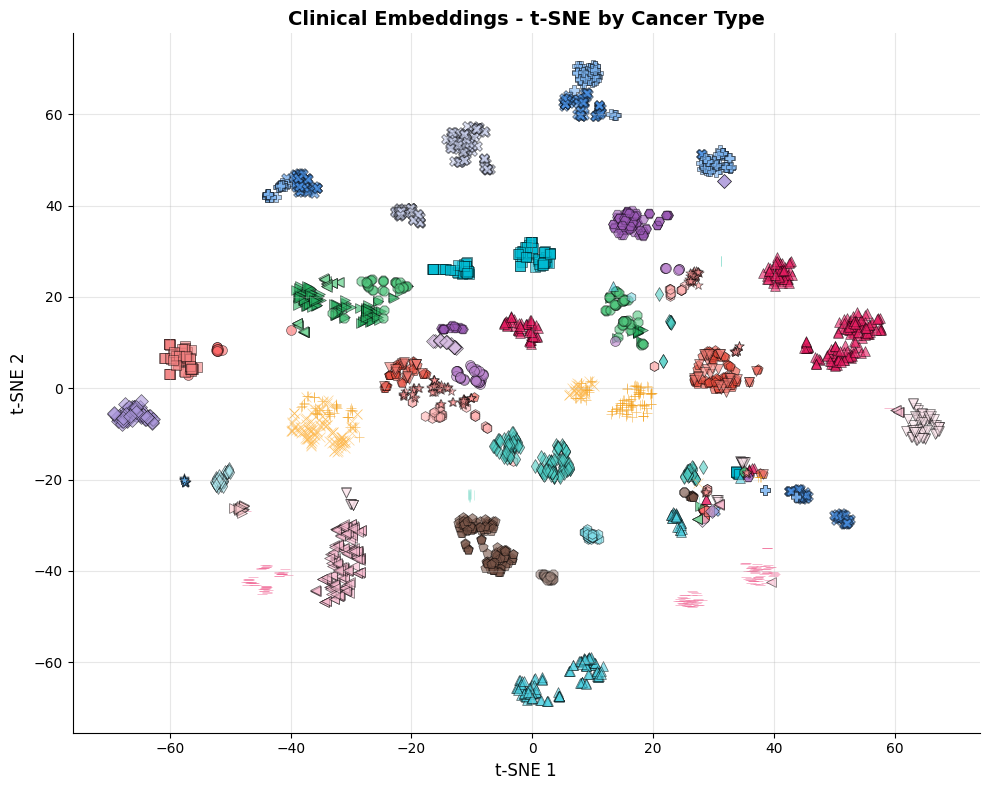

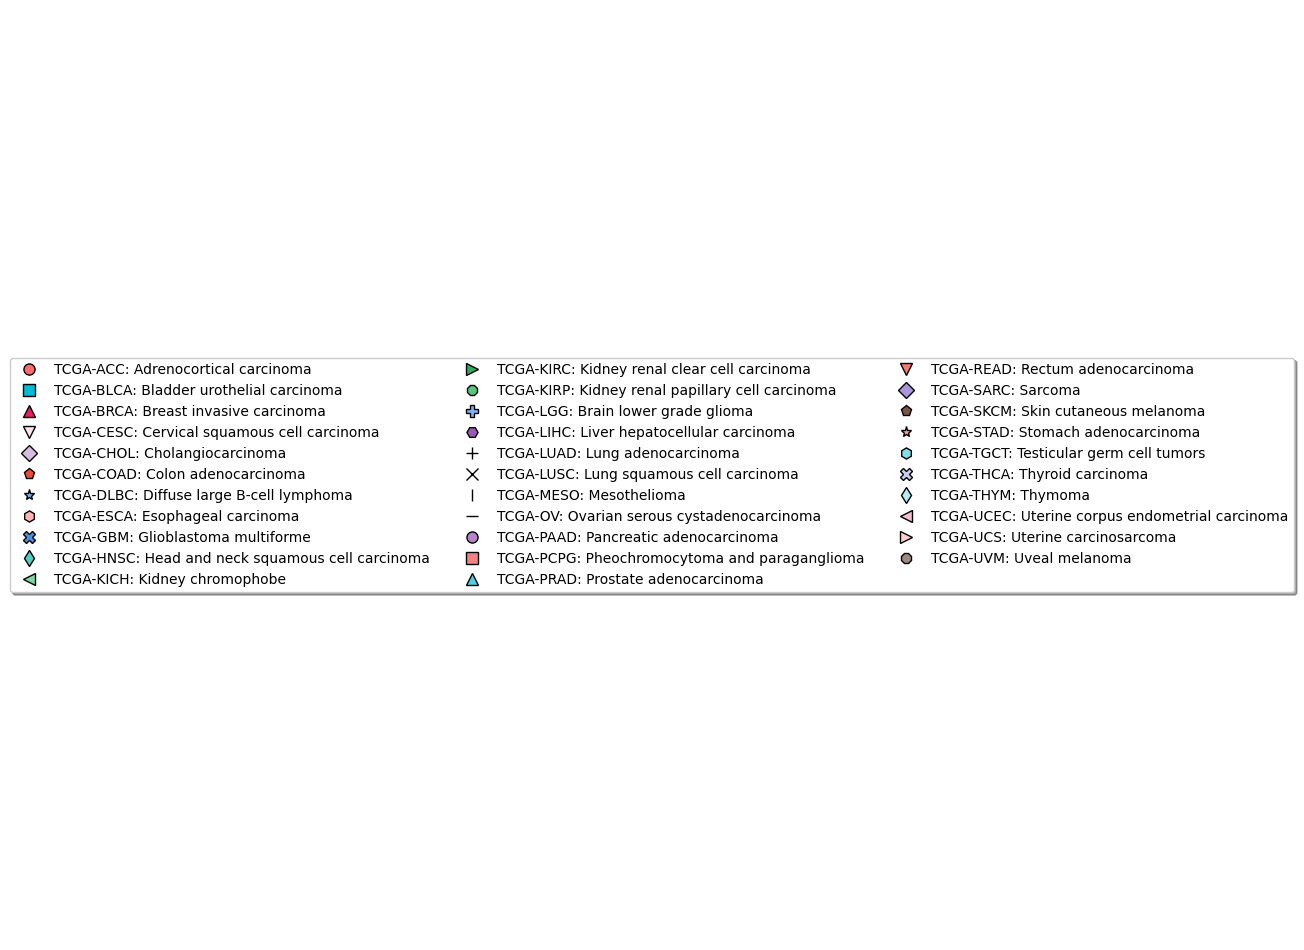

Computing t-SNE for 3000 samples...


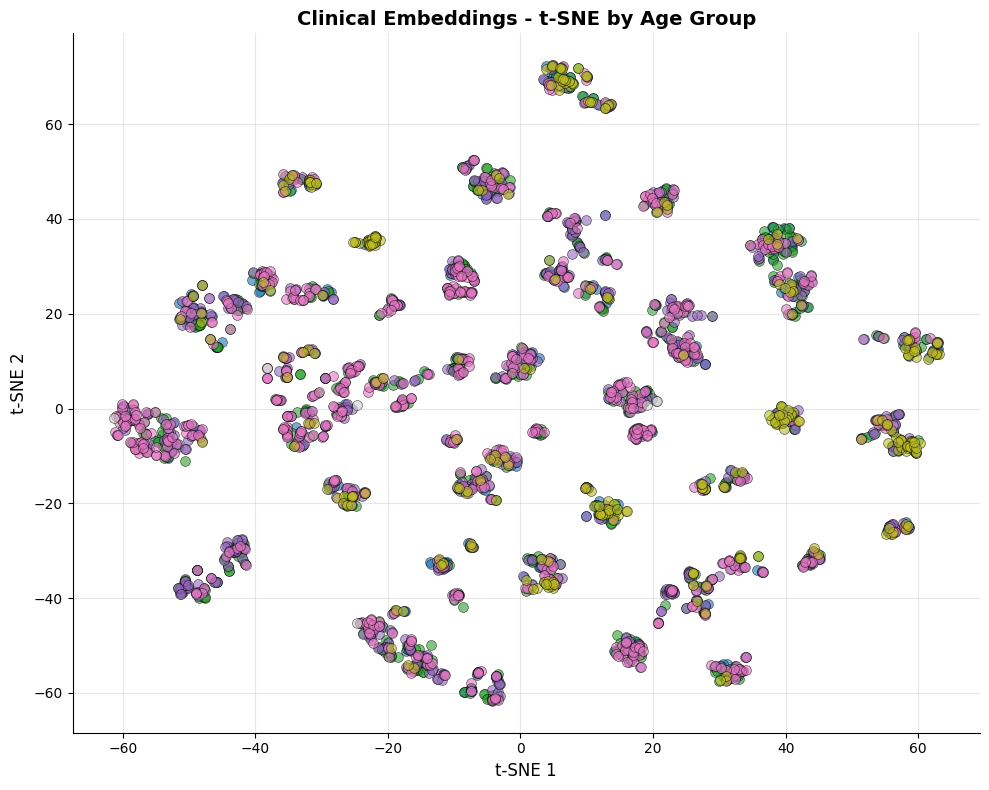

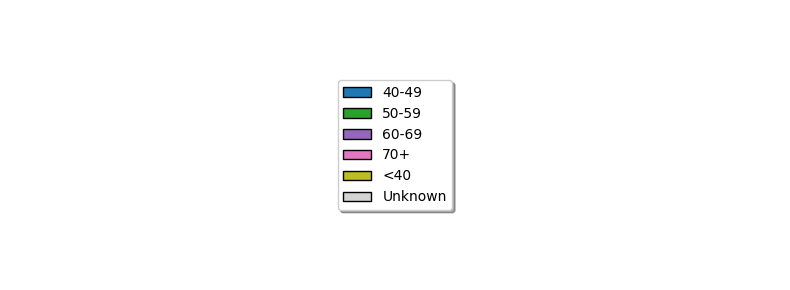

In [13]:
# Prepare clinical data for visualization
if clinical_embeddings is not None and clinical_metadata is not None:
    print(f"Clinical data: {len(clinical_metadata)} samples")
    print(f"Available columns: {list(clinical_metadata.columns)[:10]}...")  # Show first 10 columns
    
    # Add age groups if age data is available
    if 'age_at_index' in clinical_metadata.columns:
        clinical_metadata['age_group'] = clinical_metadata['age_at_index'].apply(create_age_groups)
    
    # Sample data for visualization (use 3000 samples for reasonable computation time)
    sample_size = min(3000, len(clinical_embeddings))
    
    # Visualize by cancer type (project_id)
    if 'project_id' in clinical_metadata.columns:
        labels = clinical_metadata['project_id'].values
        _ = create_tsne_visualization(
            clinical_embeddings, 
            labels,
            "Clinical Embeddings - t-SNE by Cancer Type",
            sample_size=sample_size
        )
    
    # Visualize by sex
    if 'sex' in clinical_metadata.columns:
        labels = clinical_metadata['sex'].fillna('Unknown').values
        _ = create_tsne_visualization(
            clinical_embeddings,
            labels,
            "Clinical Embeddings - t-SNE by Sex",
            sample_size=sample_size
        )
    
    # Visualize by age group
    if 'age_group' in clinical_metadata.columns:
        labels = clinical_metadata['age_group'].values
        _ = create_tsne_visualization(
            clinical_embeddings,
            labels,
            "Clinical Embeddings - t-SNE by Age Group",
            sample_size=sample_size
        )
else:
    print("Clinical embeddings not available")

### 5.2 Pathology Report Embeddings Visualization 🔬

Next, let's visualize pathology report embeddings. Since pathology metadata may be limited, we'll enrich it with patient information from our mapping to enable proper stratification:

🔬 PATHOLOGY EMBEDDINGS VISUALIZATION

📊 Pathology data statistics:
  Total samples: 10,857
  Embedding dimensions: 1024
  Available columns: ['id', 'data_format', 'access', 'file_name', 'md5sum', 'updated_datetime', 'data_type', 'data_category', 'state', 'type']...

📌 Using 3,000 samples for visualization

🔄 Enriching pathology metadata with patient information...
  ✓ Successfully enriched 10,857 samples (100.0%)

🎨 Creating visualization by cancer type...
Computing t-SNE for 3000 samples...


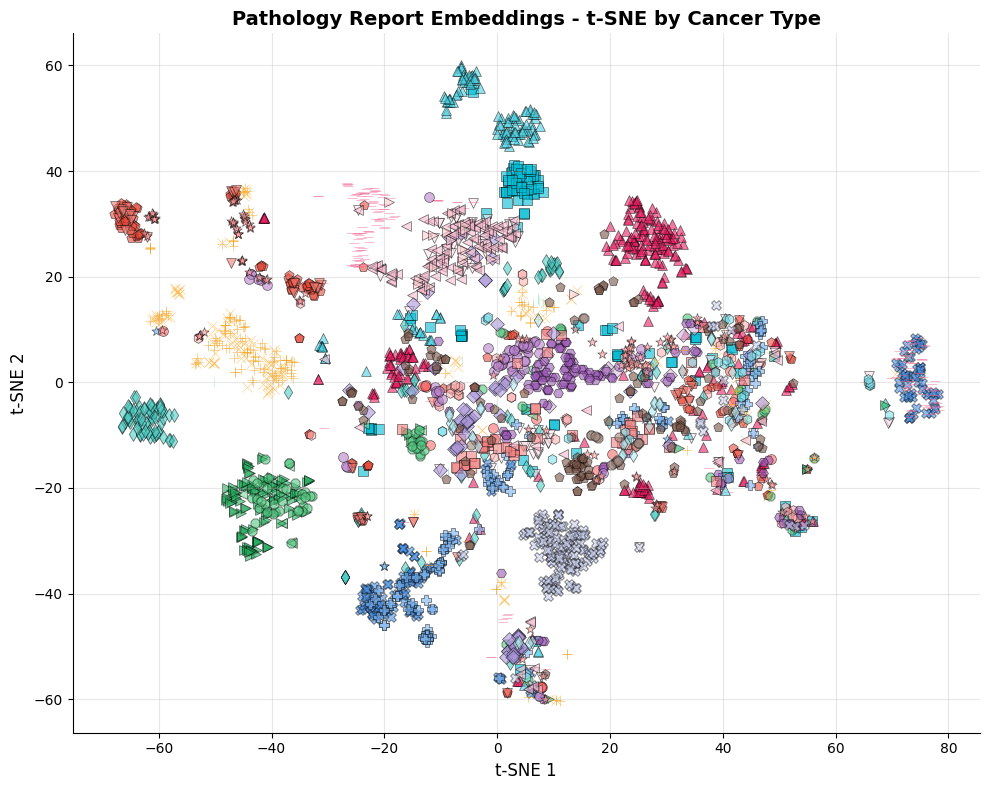

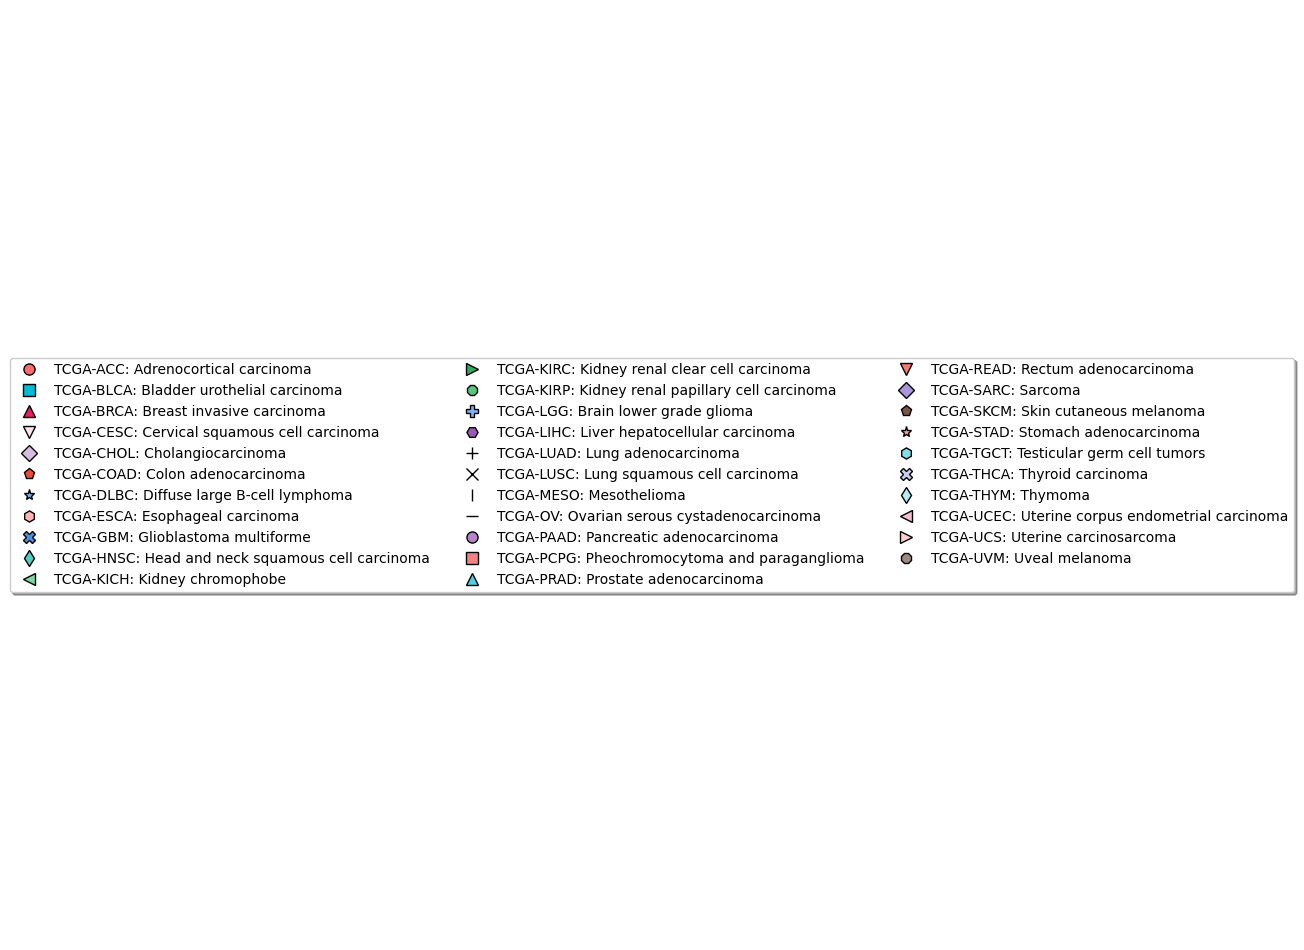


👥 Creating visualization by sex...
Computing t-SNE for 3000 samples...


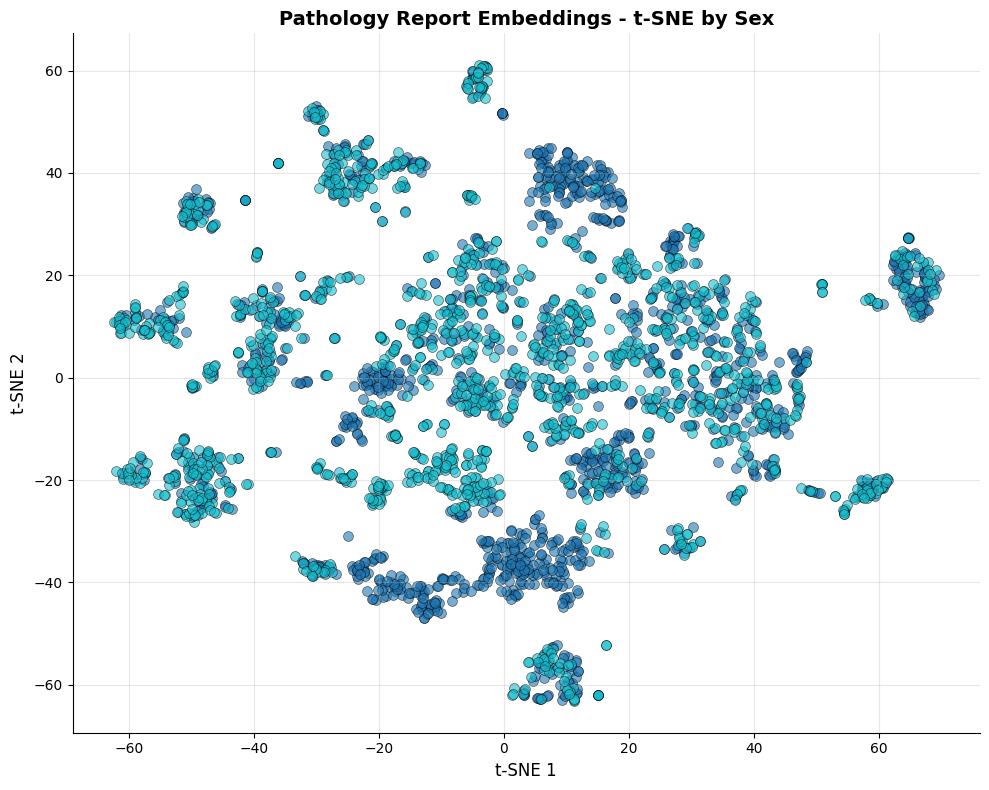

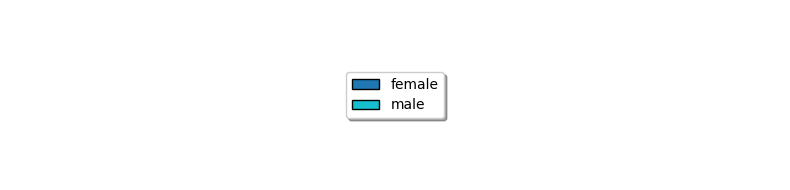


✅ Pathology visualization complete!


In [14]:
# Prepare pathology data for visualization
if pathology_embeddings is not None and pathology_metadata is not None:
    print("=" * 60)
    print("🔬 PATHOLOGY EMBEDDINGS VISUALIZATION")
    print("=" * 60)
    
    print(f"\n📊 Pathology data statistics:")
    print(f"  Total samples: {len(pathology_metadata):,}")
    print(f"  Embedding dimensions: {pathology_embeddings.shape[1]}")
    print(f"  Available columns: {list(pathology_metadata.columns)[:10]}...")
    
    # Sample data for visualization
    sample_size = min(3000, len(pathology_embeddings))
    print(f"\n📌 Using {sample_size:,} samples for visualization")
    
    # Try to enrich pathology metadata with clinical information
    print("\n🔄 Enriching pathology metadata with patient information...")
    enriched_pathology = []
    mapped_count = 0
    
    for i in range(len(pathology_metadata)):
        patient_id = pathology_metadata.iloc[i].get('PatientID', None)
        if patient_id and patient_id in patient_modality_map:
            # Get project_id from patient mapping
            project_id = patient_modality_map[patient_id].get('project_id', 'Unknown')
            gender = patient_modality_map[patient_id].get('gender', 'Unknown')
            age = patient_modality_map[patient_id].get('age_at_index', None)
            enriched_pathology.append({
                'PatientID': patient_id,
                'project_id': project_id,
                'gender': gender,
                'age_at_index': age,
                'age_group': create_age_groups(age)
            })
            mapped_count += 1
        else:
            enriched_pathology.append({
                'PatientID': patient_id,
                'project_id': 'Unknown',
                'gender': 'Unknown',
                'age_at_index': None,
                'age_group': 'Unknown'
            })
    
    enriched_pathology_df = pd.DataFrame(enriched_pathology)
    print(f"  ✓ Successfully enriched {mapped_count:,} samples ({(mapped_count/len(pathology_metadata))*100:.1f}%)")
    
    # Visualize by cancer type
    print("\n🎨 Creating visualization by cancer type...")
    labels = enriched_pathology_df['project_id'].values
    _ = create_tsne_visualization(
        pathology_embeddings,
        labels,
        "Pathology Report Embeddings - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by gender if we have enriched data
    if 'gender' in enriched_pathology_df.columns:
        print("\n👥 Creating visualization by sex...")
        labels = enriched_pathology_df['gender'].values
        _ = create_tsne_visualization(
            pathology_embeddings,
            labels,
            "Pathology Report Embeddings - t-SNE by Sex",
            sample_size=sample_size
        )
    
    print("\n✅ Pathology visualization complete!")
else:
    print("❌ Pathology embeddings not available")

### 5.3 WSI (Whole Slide Image) Embeddings Visualization 🔬

Visualize WSI embeddings from digital pathology slides. These embeddings capture tissue architecture and cellular morphology features.

🔬 WSI EMBEDDINGS VISUALIZATION

📊 WSI data statistics:
  Total patients: 8,060
  Embedding dimensions: 1024

📌 Using 3,000 samples for visualization

🔄 Enriching WSI metadata with patient information...
  ✓ Successfully enriched 8,060 samples (100.0%)

📊 Slide statistics per patient:
  Average slides: 2.8
  Maximum slides: 16

🎨 Creating visualization by cancer type...
Computing t-SNE for 3000 samples...


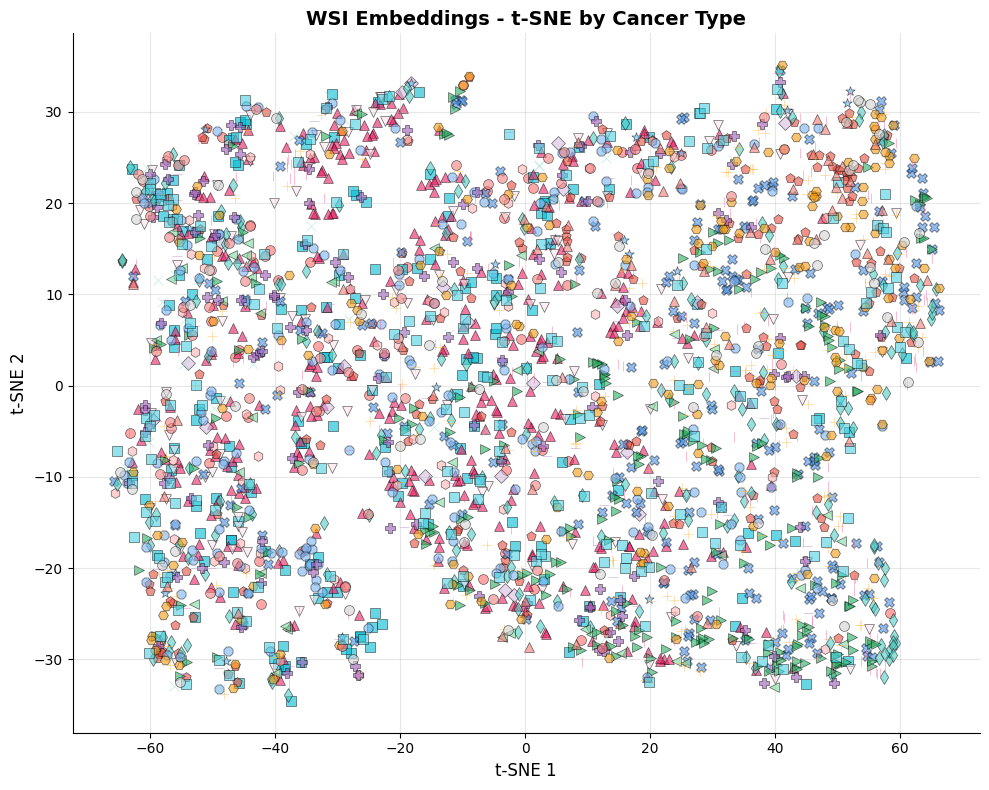

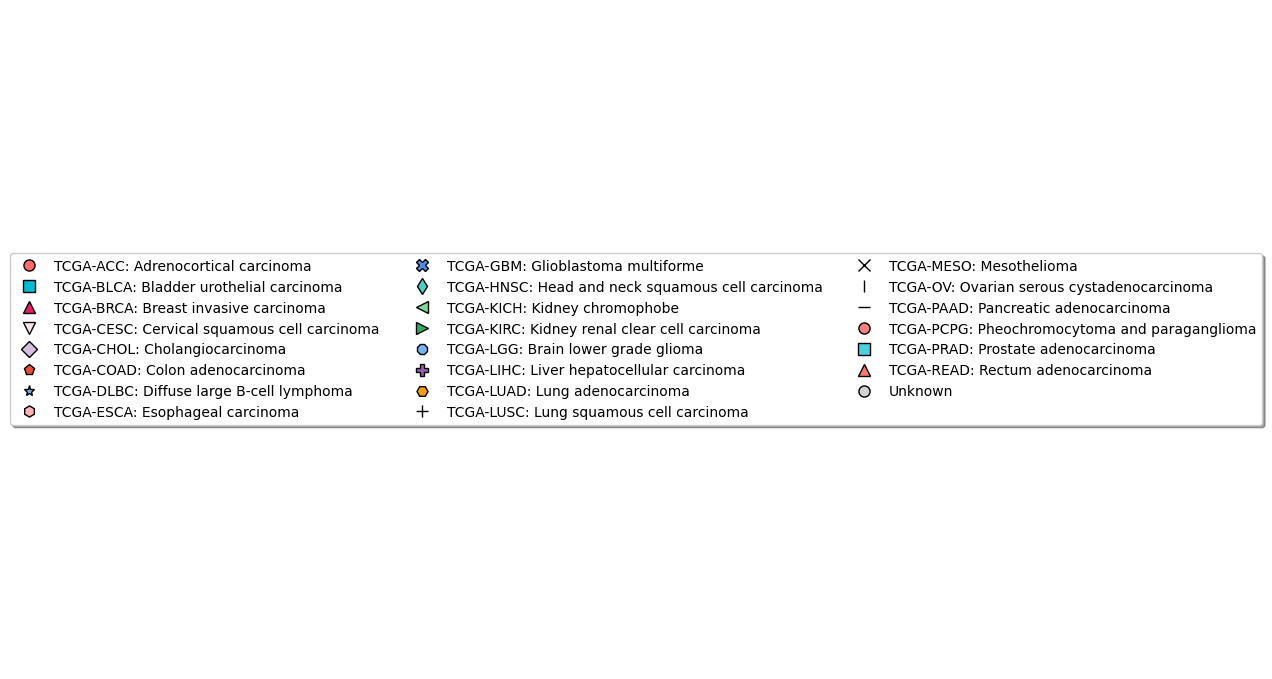


👥 Creating visualization by sex...
Computing t-SNE for 3000 samples...


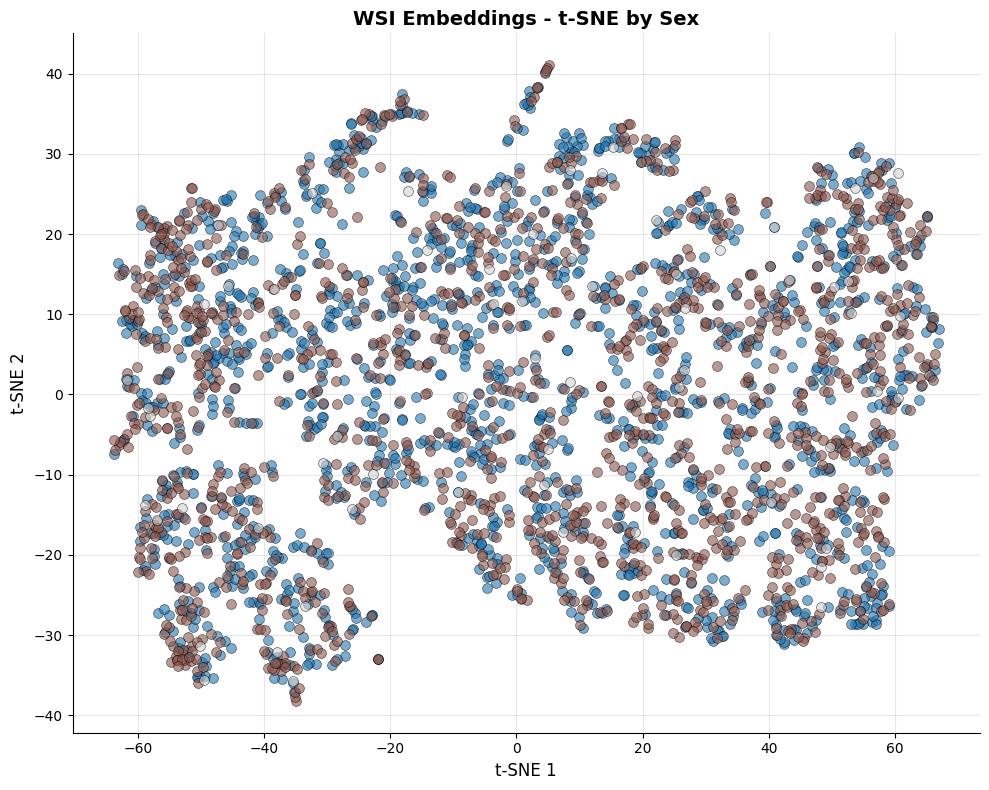

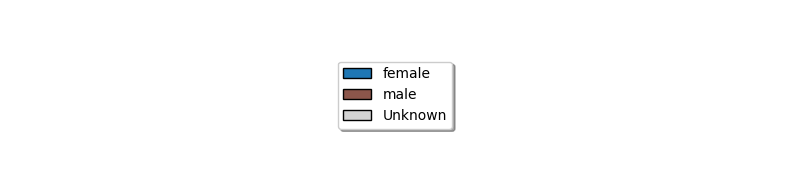


📅 Creating visualization by age group...
Computing t-SNE for 3000 samples...


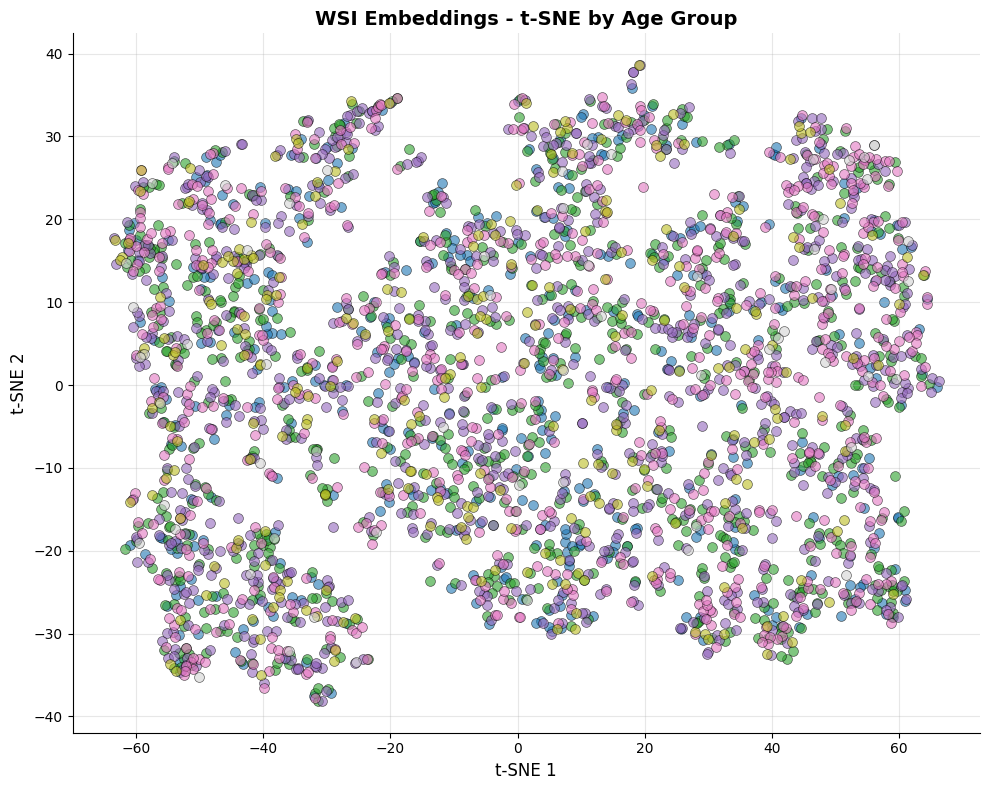

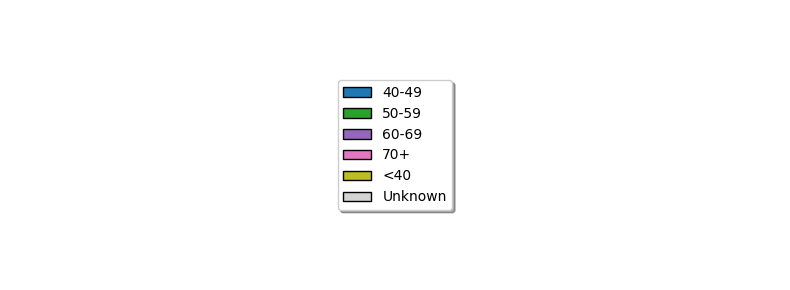


✅ WSI visualization complete!


In [15]:
# Prepare WSI data for visualization (using patient-level aggregated data)
if wsi_embeddings is not None and wsi_metadata is not None:
    print("=" * 60)
    print("🔬 WSI EMBEDDINGS VISUALIZATION")
    print("=" * 60)
    
    print(f"\n📊 WSI data statistics:")
    print(f"  Total patients: {len(wsi_metadata):,}")
    print(f"  Embedding dimensions: {wsi_embeddings.shape[1]}")
    
    # Sample data for visualization
    sample_size = min(3000, len(wsi_embeddings))
    print(f"\n📌 Using {sample_size:,} samples for visualization")
    
    # Enrich WSI metadata with clinical information
    print("\n🔄 Enriching WSI metadata with patient information...")
    enriched_wsi = []
    mapped_count = 0
    
    for i in range(len(wsi_metadata)):
        patient_id = wsi_metadata.iloc[i]['patient_id']
        if patient_id and patient_id in patient_modality_map:
            # Get project_id from patient mapping
            project_id = patient_modality_map[patient_id].get('project_id', 'Unknown')
            gender = patient_modality_map[patient_id].get('gender', 'Unknown')
            age = patient_modality_map[patient_id].get('age_at_index', None)
            num_slides = wsi_metadata.iloc[i].get('num_slides', 1)
            enriched_wsi.append({
                'PatientID': patient_id,
                'project_id': project_id,
                'gender': gender,
                'age_at_index': age,
                'age_group': create_age_groups(age),
                'num_slides': num_slides
            })
            mapped_count += 1
        else:
            enriched_wsi.append({
                'PatientID': patient_id,
                'project_id': 'Unknown',
                'gender': 'Unknown',
                'age_at_index': None,
                'age_group': 'Unknown',
                'num_slides': wsi_metadata.iloc[i].get('num_slides', 1)
            })
    
    enriched_wsi_df = pd.DataFrame(enriched_wsi)
    print(f"  ✓ Successfully enriched {mapped_count:,} samples ({(mapped_count/len(wsi_metadata))*100:.1f}%)")
    
    # Print slide statistics
    avg_slides = enriched_wsi_df['num_slides'].mean()
    max_slides = enriched_wsi_df['num_slides'].max()
    print(f"\n📊 Slide statistics per patient:")
    print(f"  Average slides: {avg_slides:.1f}")
    print(f"  Maximum slides: {max_slides}")
    
    # Visualize by cancer type
    print("\n🎨 Creating visualization by cancer type...")
    labels = enriched_wsi_df['project_id'].values
    _ = create_tsne_visualization(
        wsi_embeddings,
        labels,
        "WSI Embeddings - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by gender
    print("\n👥 Creating visualization by sex...")
    labels = enriched_wsi_df['gender'].values
    _ = create_tsne_visualization(
        wsi_embeddings,
        labels,
        "WSI Embeddings - t-SNE by Sex",
        sample_size=sample_size
    )
    
    # Visualize by age group
    if 'age_group' in enriched_wsi_df.columns:
        print("\n📅 Creating visualization by age group...")
        labels = enriched_wsi_df['age_group'].values
        _ = create_tsne_visualization(
            wsi_embeddings,
            labels,
            "WSI Embeddings - t-SNE by Age Group",
            sample_size=sample_size
        )
    
    print("\n✅ WSI visualization complete!")
else:
    print("❌ WSI embeddings not available")

### 5.4 Molecular Embeddings Visualization 🧬

Visualize molecular embeddings from genomic and transcriptomic data. These embeddings capture genetic signatures and expression patterns.

🧬 MOLECULAR EMBEDDINGS VISUALIZATION

📊 Molecular data statistics:
  Total samples: 13,804
  Embedding dimensions: 48
  Available columns: ['PatientID', 'SampleID', 'modality', 'original_shape']...

📌 Using 3,000 samples for visualization

🔄 Enriching molecular metadata with patient information...
  ✓ Successfully enriched 13,804 samples (100.0%)

🎨 Creating visualization by cancer type...
Computing t-SNE for 3000 samples...


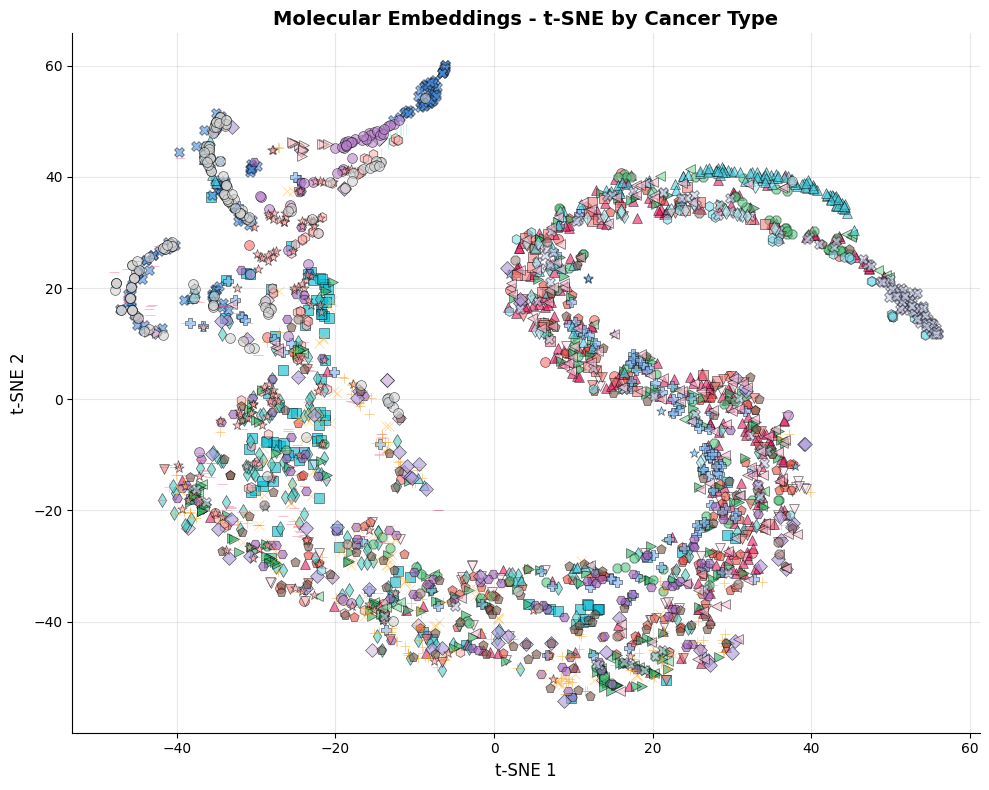

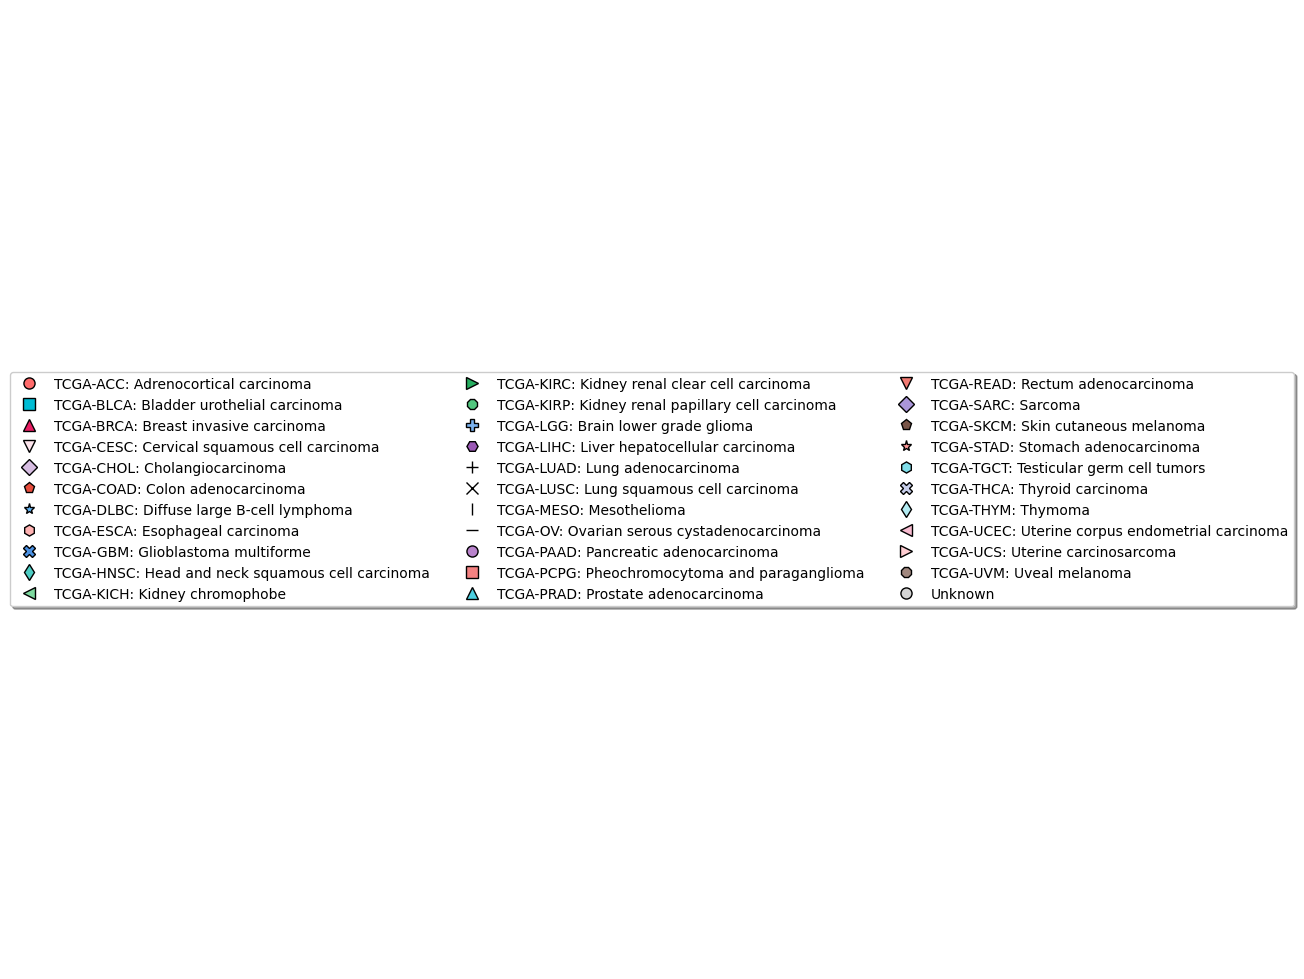


👥 Creating visualization by sex...
Computing t-SNE for 3000 samples...


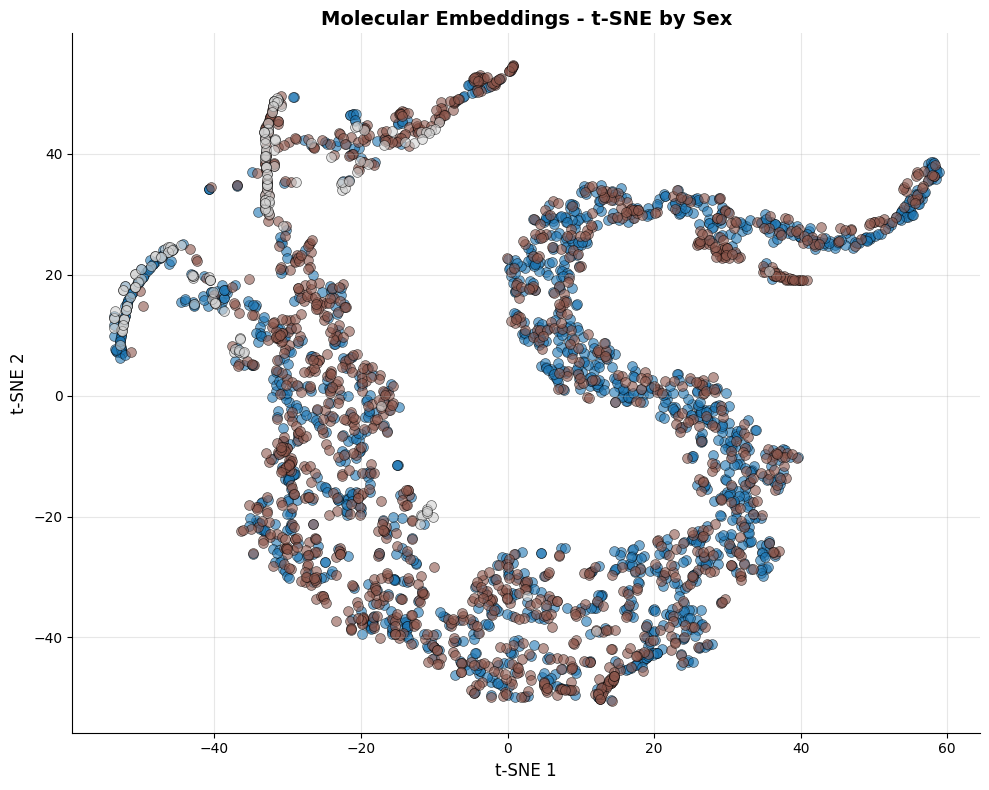

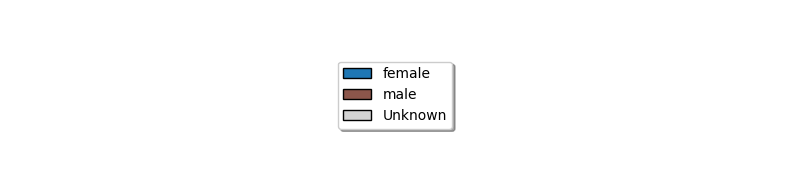


📅 Creating visualization by age group...
Computing t-SNE for 3000 samples...


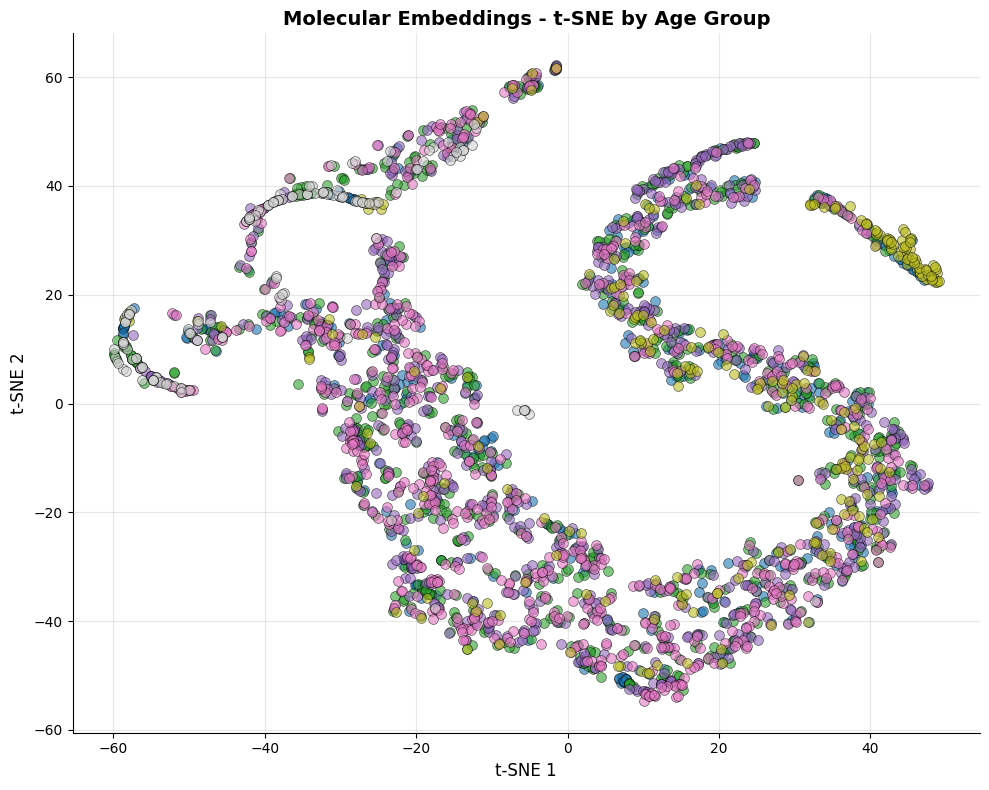

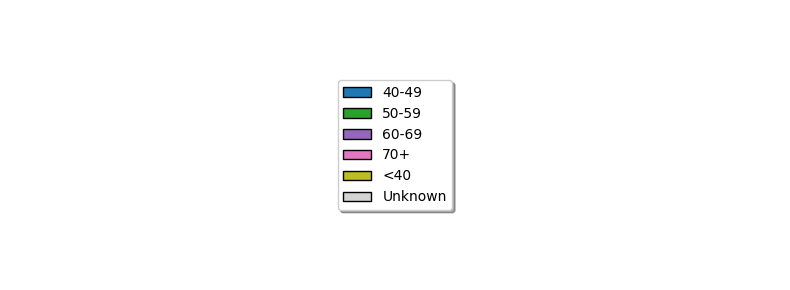


✅ Molecular visualization complete!


In [16]:
# Prepare molecular data for visualization
if molecular_embeddings is not None and molecular_metadata is not None:
    print("=" * 60)
    print("🧬 MOLECULAR EMBEDDINGS VISUALIZATION")
    print("=" * 60)
    
    print(f"\n📊 Molecular data statistics:")
    print(f"  Total samples: {len(molecular_metadata):,}")
    print(f"  Embedding dimensions: {molecular_embeddings.shape[1]}")
    print(f"  Available columns: {list(molecular_metadata.columns)[:10]}...")
    
    # Sample data for visualization
    sample_size = min(3000, len(molecular_embeddings))
    print(f"\n📌 Using {sample_size:,} samples for visualization")
    
    # Enrich molecular metadata with clinical information
    print("\n🔄 Enriching molecular metadata with patient information...")
    enriched_molecular = []
    mapped_count = 0
    
    for i in range(len(molecular_metadata)):
        patient_id = molecular_metadata.iloc[i].get('PatientID', 
                    molecular_metadata.iloc[i].get('case_submitter_id', None))
        if patient_id and patient_id in patient_modality_map:
            # Get project_id from patient mapping
            project_id = patient_modality_map[patient_id].get('project_id', 'Unknown')
            gender = patient_modality_map[patient_id].get('gender', 'Unknown')
            age = patient_modality_map[patient_id].get('age_at_index', None)
            enriched_molecular.append({
                'PatientID': patient_id,
                'project_id': project_id,
                'gender': gender,
                'age_at_index': age,
                'age_group': create_age_groups(age),
                'sample_id': molecular_metadata.iloc[i].get('SampleID', 'Unknown')
            })
            mapped_count += 1
        else:
            enriched_molecular.append({
                'PatientID': patient_id,
                'project_id': 'Unknown',
                'gender': 'Unknown',
                'age_at_index': None,
                'age_group': 'Unknown',
                'sample_id': molecular_metadata.iloc[i].get('SampleID', 'Unknown')
            })
    
    enriched_molecular_df = pd.DataFrame(enriched_molecular)
    print(f"  ✓ Successfully enriched {mapped_count:,} samples ({(mapped_count/len(molecular_metadata))*100:.1f}%)")
    
    # Visualize by cancer type
    print("\n🎨 Creating visualization by cancer type...")
    labels = enriched_molecular_df['project_id'].values
    _ = create_tsne_visualization(
        molecular_embeddings,
        labels,
        "Molecular Embeddings - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by gender
    print("\n👥 Creating visualization by sex...")
    labels = enriched_molecular_df['gender'].values
    _ = create_tsne_visualization(
        molecular_embeddings,
        labels,
        "Molecular Embeddings - t-SNE by Sex",
        sample_size=sample_size
    )
    
    # Visualize by age group
    if 'age_group' in enriched_molecular_df.columns:
        print("\n📅 Creating visualization by age group...")
        labels = enriched_molecular_df['age_group'].values
        _ = create_tsne_visualization(
            molecular_embeddings,
            labels,
            "Molecular Embeddings - t-SNE by Age Group",
            sample_size=sample_size
        )
    
    print("\n✅ Molecular visualization complete!")
else:
    print("❌ Molecular embeddings not available")

### 5.5 Radiology Embeddings Visualization 🏥

Visualize radiology embeddings from medical imaging (CT/MRI scans). These embeddings capture anatomical and functional imaging characteristics.

🏥 RADIOLOGY EMBEDDINGS VISUALIZATION

📊 Radiology data statistics:
  Total patients: 1,149
  Embedding dimensions: 1000

📌 Using 1,149 samples for visualization

🔄 Enriching radiology metadata with patient information...
  ✓ Successfully enriched 1,149 samples (100.0%)

📊 Scan statistics per patient:
  Average scans: 9.7
  Average slices: 9.7
  Maximum scans: 93
  Maximum slices: 93

🎨 Creating visualization by cancer type...
Computing t-SNE for 1149 samples...


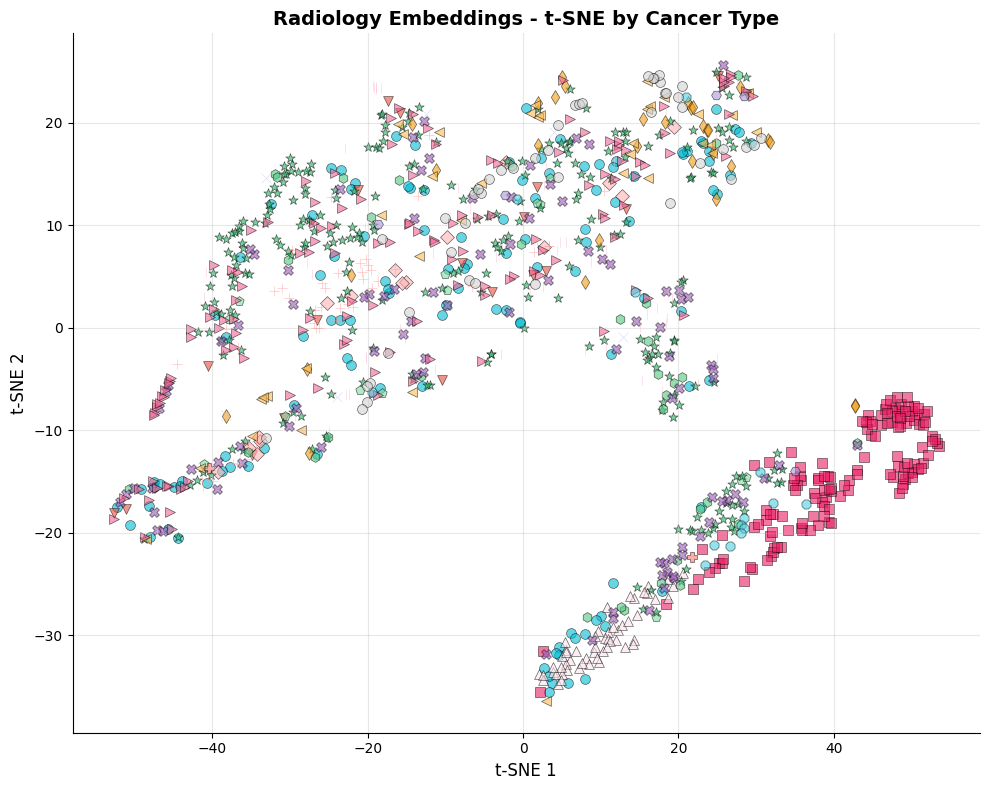

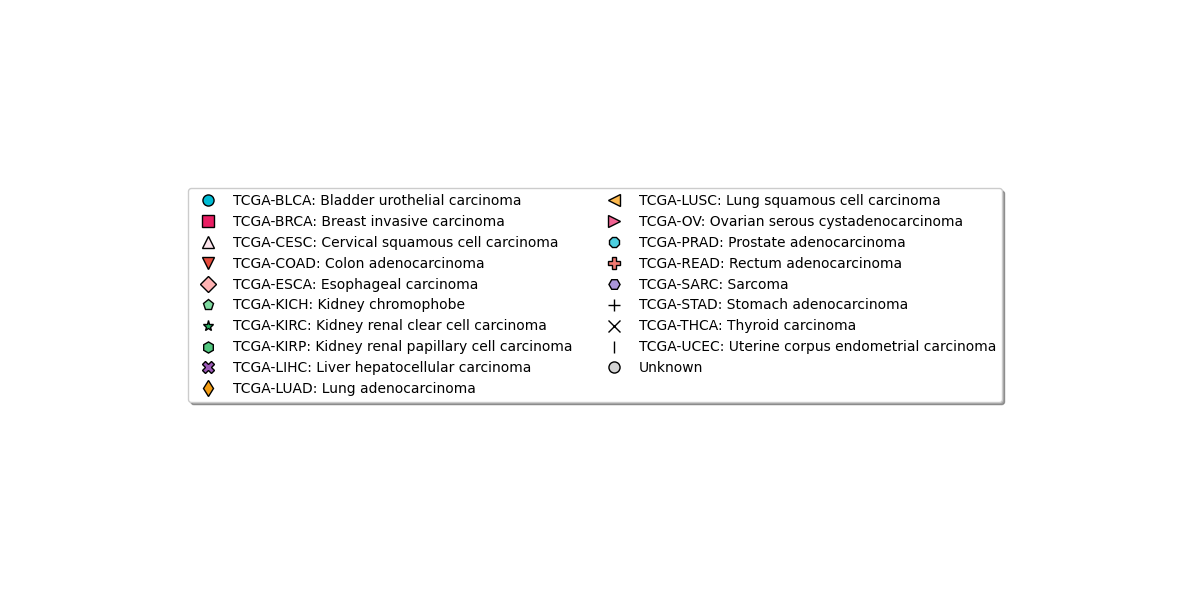


👥 Creating visualization by sex...
Computing t-SNE for 1149 samples...


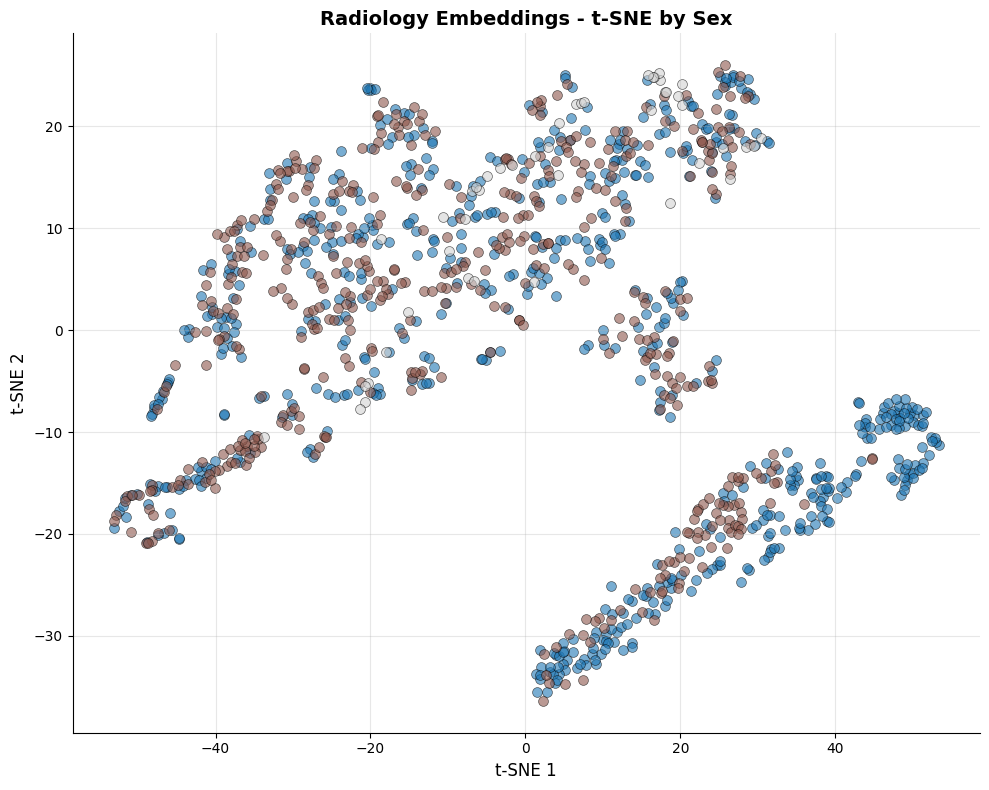

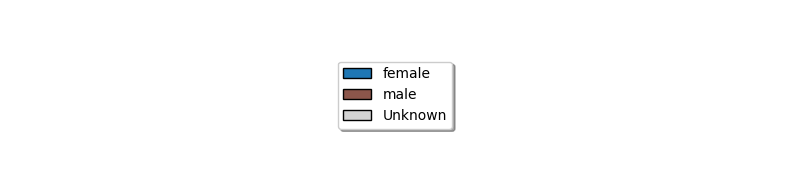


📅 Creating visualization by age group...
Computing t-SNE for 1149 samples...


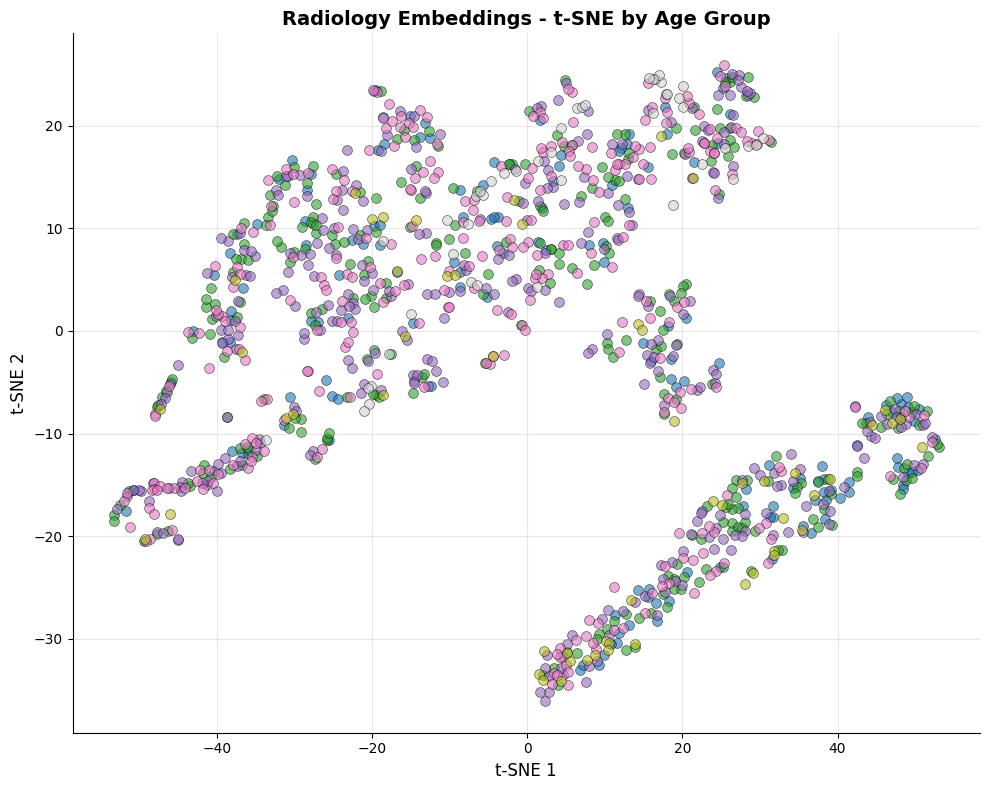

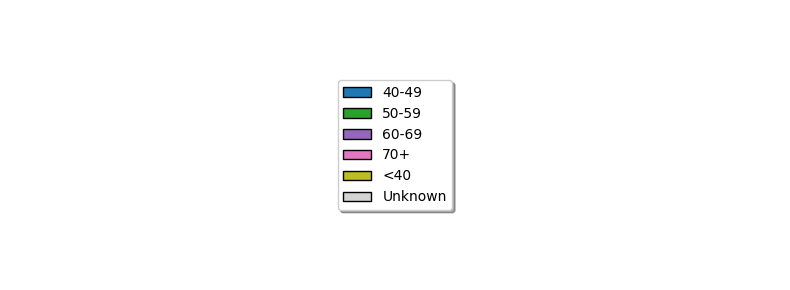


✅ Radiology visualization complete!


In [17]:
# Prepare radiology data for visualization (using patient-level aggregated data)
if radiology_embeddings is not None and radiology_metadata is not None:
    print("=" * 60)
    print("🏥 RADIOLOGY EMBEDDINGS VISUALIZATION")
    print("=" * 60)
    
    print(f"\n📊 Radiology data statistics:")
    print(f"  Total patients: {len(radiology_metadata):,}")
    print(f"  Embedding dimensions: {radiology_embeddings.shape[1]}")
    
    # Sample data for visualization
    sample_size = min(3000, len(radiology_embeddings))
    print(f"\n📌 Using {sample_size:,} samples for visualization")
    
    # Enrich radiology metadata with clinical information
    print("\n🔄 Enriching radiology metadata with patient information...")
    enriched_radiology = []
    mapped_count = 0
    
    for i in range(len(radiology_metadata)):
        patient_id = radiology_metadata.iloc[i]['patient_id']
        if patient_id and patient_id in patient_modality_map:
            # Get project_id from patient mapping
            project_id = patient_modality_map[patient_id].get('project_id', 'Unknown')
            gender = patient_modality_map[patient_id].get('gender', 'Unknown')
            age = patient_modality_map[patient_id].get('age_at_index', None)
            num_scans = radiology_metadata.iloc[i].get('num_scans', 1)
            num_slices = radiology_metadata.iloc[i].get('num_slices', 1)
            enriched_radiology.append({
                'PatientID': patient_id,
                'project_id': project_id,
                'gender': gender,
                'age_at_index': age,
                'age_group': create_age_groups(age),
                'num_scans': num_scans,
                'num_slices': num_slices
            })
            mapped_count += 1
        else:
            enriched_radiology.append({
                'PatientID': patient_id,
                'project_id': 'Unknown',
                'gender': 'Unknown',
                'age_at_index': None,
                'age_group': 'Unknown',
                'num_scans': radiology_metadata.iloc[i].get('num_scans', 1),
                'num_slices': radiology_metadata.iloc[i].get('num_slices', 1)
            })
    
    enriched_radiology_df = pd.DataFrame(enriched_radiology)
    print(f"  ✓ Successfully enriched {mapped_count:,} samples ({(mapped_count/len(radiology_metadata))*100:.1f}%)")
    
    # Print scan statistics
    avg_scans = enriched_radiology_df['num_scans'].mean()
    avg_slices = enriched_radiology_df['num_slices'].mean()
    max_scans = enriched_radiology_df['num_scans'].max()
    max_slices = enriched_radiology_df['num_slices'].max()
    print(f"\n📊 Scan statistics per patient:")
    print(f"  Average scans: {avg_scans:.1f}")
    print(f"  Average slices: {avg_slices:.1f}")
    print(f"  Maximum scans: {max_scans}")
    print(f"  Maximum slices: {max_slices}")
    
    # Visualize by cancer type
    print("\n🎨 Creating visualization by cancer type...")
    labels = enriched_radiology_df['project_id'].values
    _ = create_tsne_visualization(
        radiology_embeddings,
        labels,
        "Radiology Embeddings - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by gender
    print("\n👥 Creating visualization by sex...")
    labels = enriched_radiology_df['gender'].values
    _ = create_tsne_visualization(
        radiology_embeddings,
        labels,
        "Radiology Embeddings - t-SNE by Sex",
        sample_size=sample_size
    )
    
    # Visualize by age group
    if 'age_group' in enriched_radiology_df.columns:
        print("\n📅 Creating visualization by age group...")
        labels = enriched_radiology_df['age_group'].values
        _ = create_tsne_visualization(
            radiology_embeddings,
            labels,
            "Radiology Embeddings - t-SNE by Age Group",
            sample_size=sample_size
        )
    
    print("\n✅ Radiology visualization complete!")
else:
    print("❌ Radiology embeddings not available")

## 6. Multimodal Integration and Visualization 🔗

Now we'll explore advanced strategies for integrating embeddings across modalities. Multimodal fusion is crucial for capturing the complete picture of cancer biology.

### Fusion Methods We'll Implement:

1. **Concatenation** 📎
   - Simply concatenate embeddings from different modalities
   - Preserves all information but results in high dimensions
   
2. **Mean Pooling** 📊
   - Average embeddings across modalities  
   - Creates unified representations with equal weighting
   
3. **Kronecker Product** ⊗
   - Captures pairwise interactions between modalities
   - Reveals synergistic patterns but computationally intensive

In [18]:
def create_multimodal_embeddings_batch(patient_list, patient_modality_map, embeddings_data, max_patients=3000):
    """
    Create multimodal embeddings efficiently using batch processing
    Following the approach from create_tsne_visualizations.py
    """
    # Sample if too many patients
    if len(patient_list) > max_patients:
        print(f"\nSampling {max_patients} patients for visualization...")
        np.random.seed(42)
        patient_list = np.random.choice(patient_list, max_patients, replace=False).tolist()
    
    print(f"\nCreating multimodal embeddings for {len(patient_list)} patients...")
    
    # Prepare embeddings data dictionary - filter out None values
    embeddings_dict = {k: v for k, v in embeddings_data.items() if v is not None}
    
    # Determine maximum dimensions for each fusion method
    max_concat_dim = sum(emb.shape[1] for emb in embeddings_dict.values() if emb is not None)
    max_mean_dim = max(emb.shape[1] for emb in embeddings_dict.values() if emb is not None)
    max_kron_dim = 100  # Limited for computational efficiency
    
    # Initialize result arrays
    n_patients = len(patient_list)
    concat_embeddings = []
    mean_embeddings = []
    kron_embeddings = []
    
    # Track valid embeddings and metadata
    valid_patients = []
    patient_metadata = []
    
    # Process patients
    for idx, patient_id in enumerate(patient_list):
        if idx % 500 == 0 and idx > 0:
            print(f"  Processing patient {idx}/{n_patients}...")
        
        patient_data = patient_modality_map.get(patient_id, {})
        
        # Get embeddings for this patient
        patient_embeddings = {}
        available_modalities = []
        
        for modality in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']:
            if modality in patient_data and modality in embeddings_dict:
                mod_idx = patient_data[modality]
                if embeddings_dict[modality] is not None and mod_idx < len(embeddings_dict[modality]):
                    emb = embeddings_dict[modality][mod_idx]
                    if not np.all(np.isnan(emb)):
                        patient_embeddings[modality] = emb
                        available_modalities.append(modality)
        
        # Skip if less than 2 modalities
        if len(patient_embeddings) < 2:
            continue
        
        # Store patient metadata
        patient_meta = {
            'patient_id': patient_id,
            'project_id': patient_data.get('project_id', 'Unknown'),
            'gender': patient_data.get('gender', 'Unknown'),
            'age_at_index': patient_data.get('age_at_index', None),
            'age_group': create_age_groups(patient_data.get('age_at_index', None)),
            'modality_combination': '+'.join(sorted(available_modalities))
        }
        patient_metadata.append(patient_meta)
        valid_patients.append(patient_id)
        
        # 1. Concatenation - concatenate all available embeddings
        concat_parts = []
        for mod_name in sorted(patient_embeddings.keys()):
            concat_parts.append(patient_embeddings[mod_name])
        concat_emb = np.concatenate(concat_parts)
        concat_embeddings.append(concat_emb)
        
        # 2. Mean pooling - average embeddings (with padding if needed)
        mean_parts = []
        for mod_name in sorted(patient_embeddings.keys()):
            emb = patient_embeddings[mod_name]
            if len(emb) < max_mean_dim:
                emb = np.pad(emb, (0, max_mean_dim - len(emb)), mode='constant')
            else:
                emb = emb[:max_mean_dim]
            mean_parts.append(emb)
        mean_emb = np.mean(mean_parts, axis=0)
        mean_embeddings.append(mean_emb)
        
        # 3. Kronecker product - limited to first 10 dimensions of first 2 modalities
        sorted_mods = sorted(patient_embeddings.keys())
        if len(sorted_mods) >= 2:
            emb1 = patient_embeddings[sorted_mods[0]][:10]
            emb2 = patient_embeddings[sorted_mods[1]][:10]
            kron = np.kron(emb1, emb2)
            if len(kron) > max_kron_dim:
                kron = kron[:max_kron_dim]
            elif len(kron) < max_kron_dim:
                kron = np.pad(kron, (0, max_kron_dim - len(kron)), mode='constant')
            kron_embeddings.append(kron)
        else:
            # Fallback - just use first modality repeated
            emb = patient_embeddings[sorted_mods[0]][:max_kron_dim]
            if len(emb) < max_kron_dim:
                emb = np.pad(emb, (0, max_kron_dim - len(emb)), mode='constant')
            kron_embeddings.append(emb)
    
    # Convert to numpy arrays
    if concat_embeddings:
        # Pad concatenated embeddings to same size
        max_concat_len = max(len(emb) for emb in concat_embeddings)
        padded_concat = []
        for emb in concat_embeddings:
            if len(emb) < max_concat_len:
                padded = np.pad(emb, (0, max_concat_len - len(emb)), mode='constant')
            else:
                padded = emb
            padded_concat.append(padded)
        concat_embeddings = np.array(padded_concat)
    else:
        concat_embeddings = None
        
    mean_embeddings = np.array(mean_embeddings) if mean_embeddings else None
    kron_embeddings = np.array(kron_embeddings) if kron_embeddings else None
    patient_metadata_df = pd.DataFrame(patient_metadata) if patient_metadata else None
    
    return {
        'concat': concat_embeddings,
        'mean_pool': mean_embeddings,
        'kronecker': kron_embeddings,
        'metadata': patient_metadata_df,
        'patient_list': valid_patients
    }

### 6.1 Prepare Multimodal Data 📋

First, let's identify patients with multiple modalities and prepare the data for fusion. This step ensures proper alignment across different data sources.

In [19]:
print("=" * 60)
print("🔗 MULTIMODAL DATA PREPARATION")
print("=" * 60)

# Get patients with 2+ modalities using the updated mapping
print("\n🔍 Identifying patients with multiple modalities...")
multimodal_patients = []
modality_combo_counts = {}

for patient_id, patient_data in patient_modality_map.items():
    modalities = [k for k in patient_data.keys() if k in ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']]
    if len(modalities) >= 2:
        multimodal_patients.append(patient_id)
        combo = '+'.join(sorted(modalities))
        modality_combo_counts[combo] = modality_combo_counts.get(combo, 0) + 1

print(f"\n✓ Total patients with 2+ modalities: {len(multimodal_patients):,}")

# Show top modality combinations
print("\n📊 Top 5 modality combinations:")
for combo, count in sorted(modality_combo_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    percentage = (count / len(multimodal_patients)) * 100
    print(f"  • {combo}: {count:,} patients ({percentage:.1f}%)")

# Create multimodal embeddings using the batch processing function
# Now using the patient-level aggregated embeddings for WSI and radiology
print("\n🔄 Creating multimodal embeddings with patient-level data...")
embeddings_data = {
    'clinical': clinical_embeddings,
    'pathology': pathology_embeddings,
    'wsi': wsi_embeddings,  # Now patient-level aggregated
    'molecular': molecular_embeddings,
    'radiology': radiology_embeddings  # Now patient-level aggregated
}

multimodal_results = create_multimodal_embeddings_batch(
    multimodal_patients, 
    patient_modality_map, 
    embeddings_data,
    max_patients=3000
)

print(f"\n✅ Multimodal embeddings successfully created:")
print(f"  📎 Concatenation: {multimodal_results['concat'].shape if multimodal_results['concat'] is not None else 'None'}")
print(f"  📊 Mean pooling: {multimodal_results['mean_pool'].shape if multimodal_results['mean_pool'] is not None else 'None'}")
print(f"  ⊗ Kronecker product: {multimodal_results['kronecker'].shape if multimodal_results['kronecker'] is not None else 'None'}")
print(f"  👥 Valid patients: {len(multimodal_results['patient_list']):,}")

🔗 MULTIMODAL DATA PREPARATION

🔍 Identifying patients with multiple modalities...

✓ Total patients with 2+ modalities: 10,790

📊 Top 5 modality combinations:
  • clinical+molecular+pathology+wsi: 6,937 patients (64.3%)
  • clinical+molecular+pathology: 2,702 patients (25.0%)
  • clinical+molecular+pathology+radiology+wsi: 949 patients (8.8%)
  • clinical+molecular+pathology+radiology: 155 patients (1.4%)
  • clinical+pathology+wsi: 19 patients (0.2%)

🔄 Creating multimodal embeddings with patient-level data...

Sampling 3000 patients for visualization...

Creating multimodal embeddings for 3000 patients...
  Processing patient 500/3000...
  Processing patient 1000/3000...
  Processing patient 1500/3000...
  Processing patient 2000/3000...
  Processing patient 2500/3000...

✅ Multimodal embeddings successfully created:
  📎 Concatenation: (3000, 4120)
  📊 Mean pooling: (3000, 1024)
  ⊗ Kronecker product: (3000, 100)
  👥 Valid patients: 3,000


### 6.2 Multimodal Fusion: Concatenation 📎

Concatenation is the simplest fusion method - we join embeddings end-to-end. This preserves all information from each modality.

📎 CONCATENATION FUSION ANALYSIS

📊 Concatenated embeddings statistics:
  Shape: (3000, 4120)
  Memory usage: 47.15 MB

🎨 Creating t-SNE visualization by cancer type...
Computing t-SNE for 3000 samples...


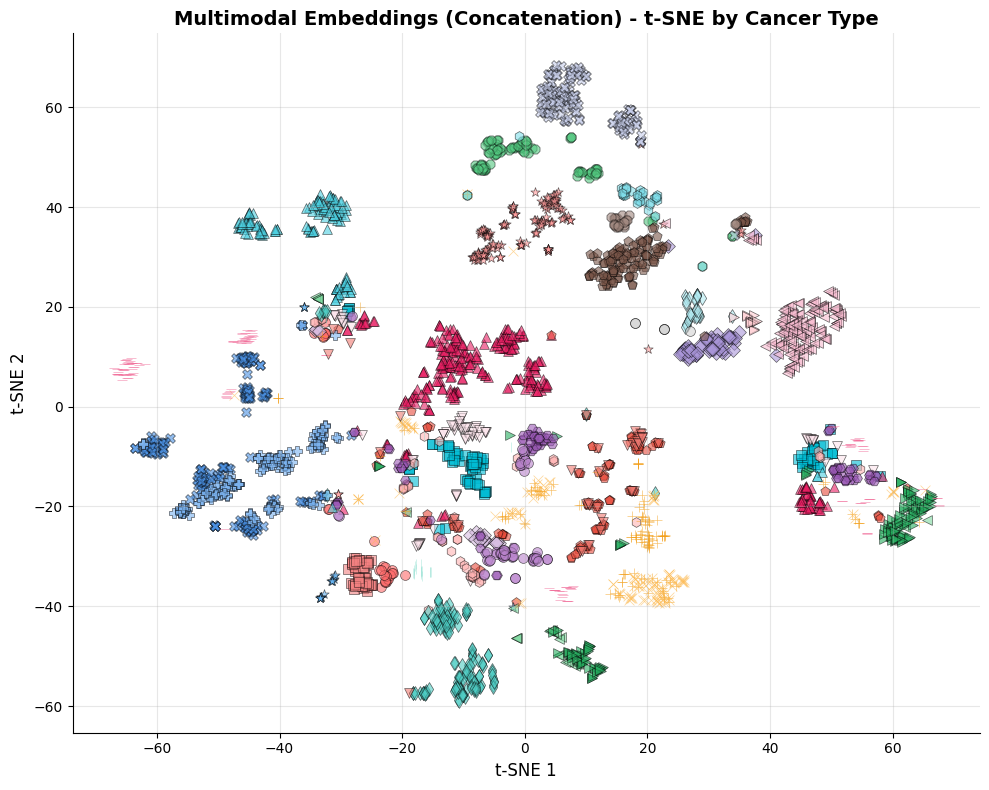

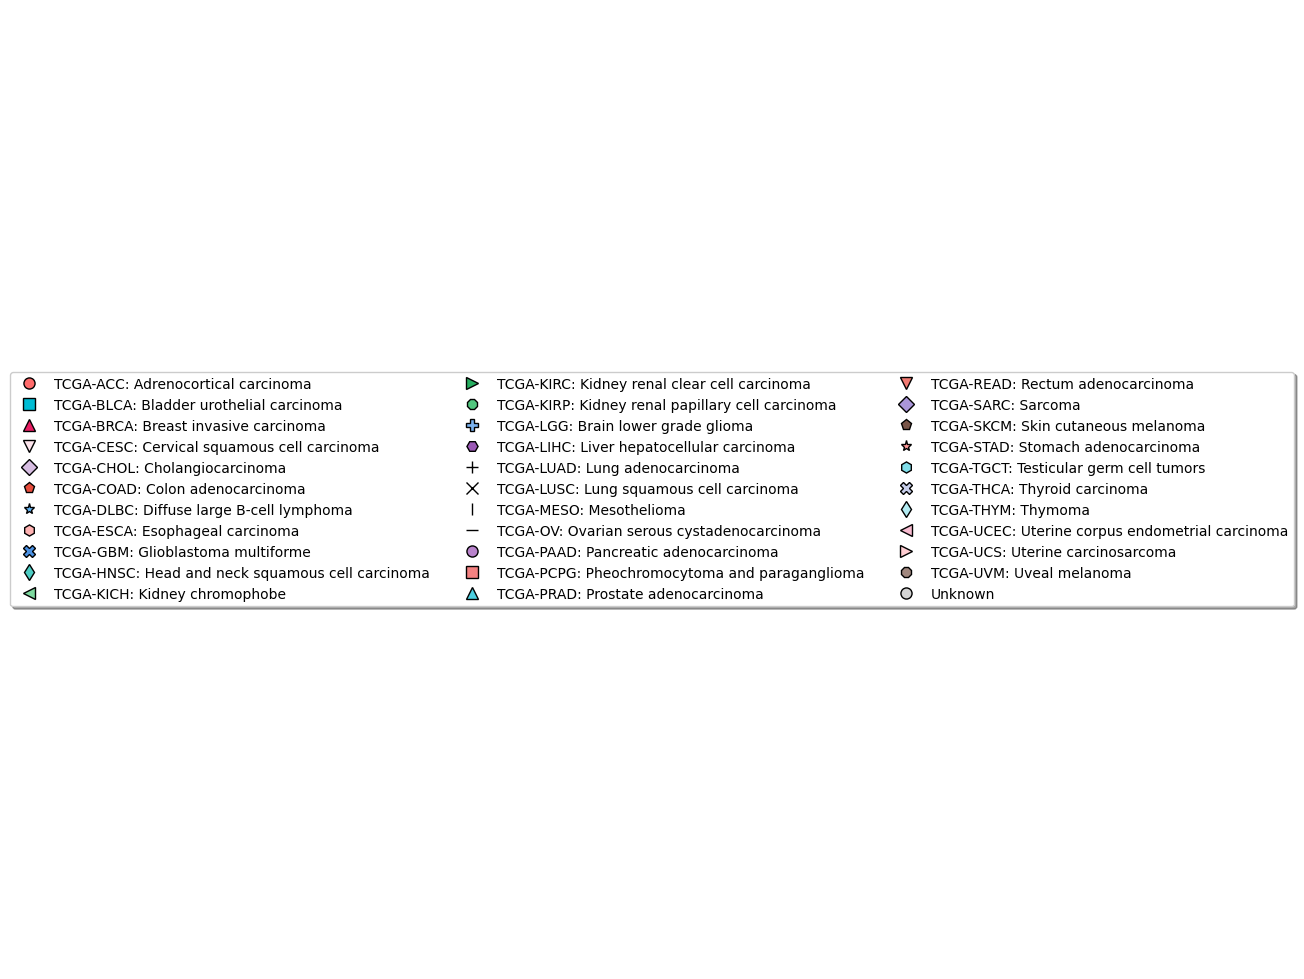


🔗 Creating t-SNE visualization by modality combination...
Computing t-SNE for 3000 samples...


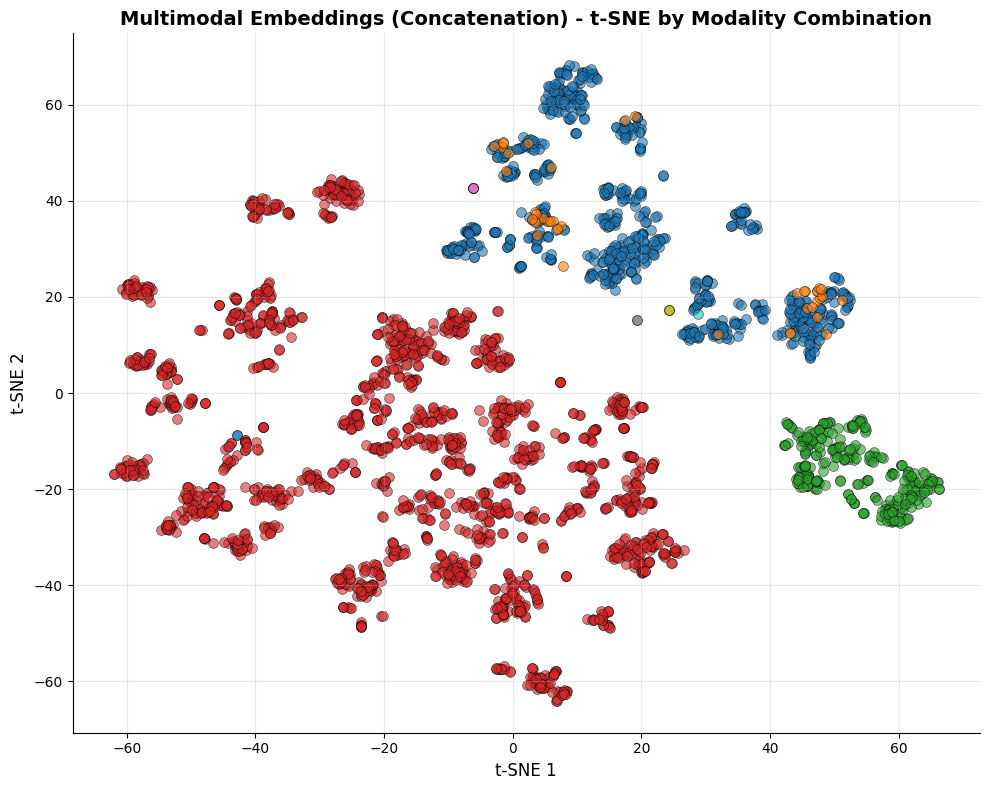

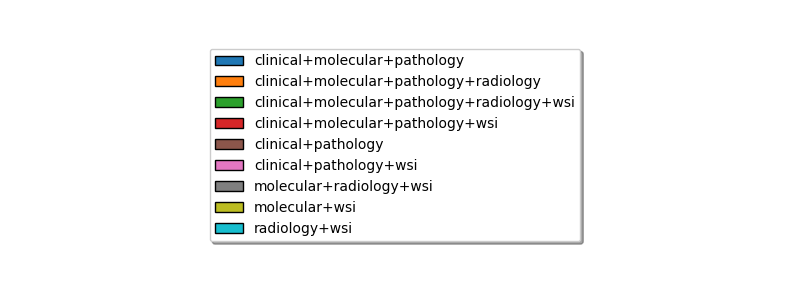


📈 Modality combination statistics:
--------------------------------------------------
                      modality_combination  count  percentage
          clinical+molecular+pathology+wsi   1882       62.73
              clinical+molecular+pathology    779       25.97
clinical+molecular+pathology+radiology+wsi    284        9.47
    clinical+molecular+pathology+radiology     44        1.47
                             molecular+wsi      3        0.10
                    clinical+pathology+wsi      3        0.10
                        clinical+pathology      2        0.07
                   molecular+radiology+wsi      2        0.07
                             radiology+wsi      1        0.03
--------------------------------------------------

✅ Concatenation fusion analysis complete!


In [20]:
if multimodal_results['concat'] is not None:
    print("=" * 60)
    print("📎 CONCATENATION FUSION ANALYSIS")
    print("=" * 60)
    
    # Concatenation fusion
    concat_embeddings = multimodal_results['concat']
    metadata = multimodal_results['metadata']
    
    print(f"\n📊 Concatenated embeddings statistics:")
    print(f"  Shape: {concat_embeddings.shape}")
    print(f"  Memory usage: {concat_embeddings.nbytes / (1024**2):.2f} MB")
    
    # Sample for visualization
    sample_size = min(3000, len(concat_embeddings))
    
    # Visualize by cancer type
    print("\n🎨 Creating t-SNE visualization by cancer type...")
    labels = metadata['project_id'].values
    _ = create_tsne_visualization(
        concat_embeddings,
        labels,
        "Multimodal Embeddings (Concatenation) - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by modality combination
    print("\n🔗 Creating t-SNE visualization by modality combination...")
    labels = metadata['modality_combination'].values
    _ = create_tsne_visualization(
        concat_embeddings,
        labels,
        "Multimodal Embeddings (Concatenation) - t-SNE by Modality Combination",
        sample_size=sample_size
    )
    
    # Save modality combination statistics
    combo_counts = metadata['modality_combination'].value_counts()
    combo_stats = pd.DataFrame({
        'modality_combination': combo_counts.index,
        'count': combo_counts.values,
        'percentage': (combo_counts.values / len(metadata) * 100).round(2)
    })
    
    print("\n📈 Modality combination statistics:")
    print("-" * 50)
    print(combo_stats.to_string(index=False))
    print("-" * 50)
    
    print("\n✅ Concatenation fusion analysis complete!")
else:
    print("❌ No multimodal concatenation embeddings available")

### 6.3 Multimodal Fusion: Mean Pooling 📊

Mean pooling creates a unified representation by averaging embeddings across modalities. This assumes equal importance for all modalities.

📊 MEAN POOLING FUSION ANALYSIS

📊 Mean pooled embeddings statistics:
  Shape: (3000, 1024)
  Memory usage: 11.72 MB
  Dimension reduction: 4.0x

🎨 Creating t-SNE visualization by cancer type...
Computing t-SNE for 3000 samples...


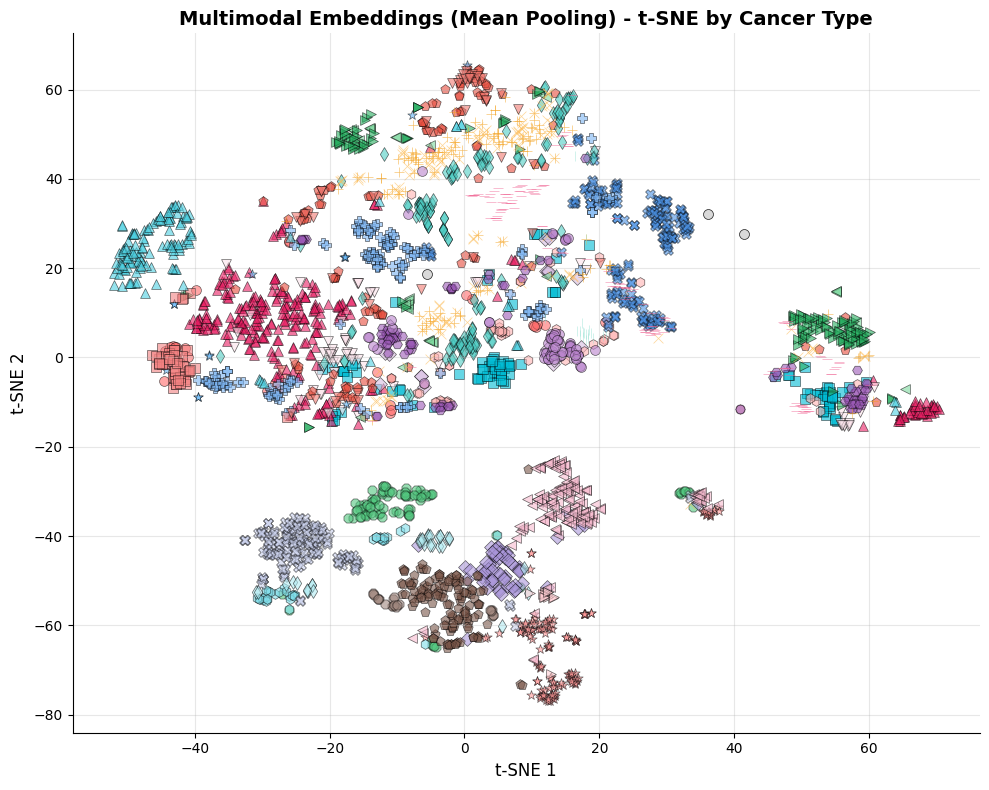

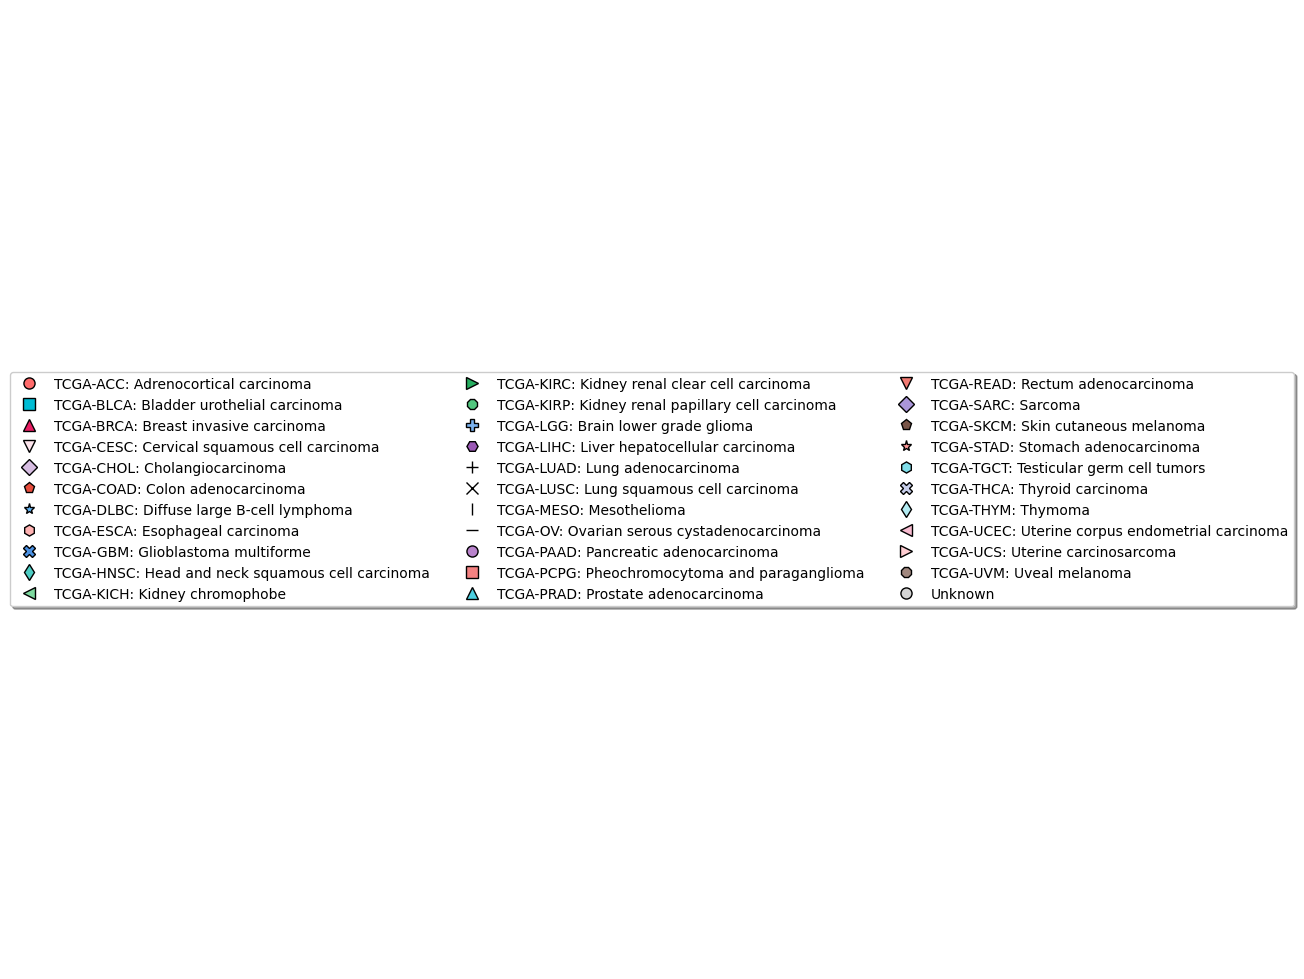


👥 Creating t-SNE visualization by sex...
Computing t-SNE for 3000 samples...


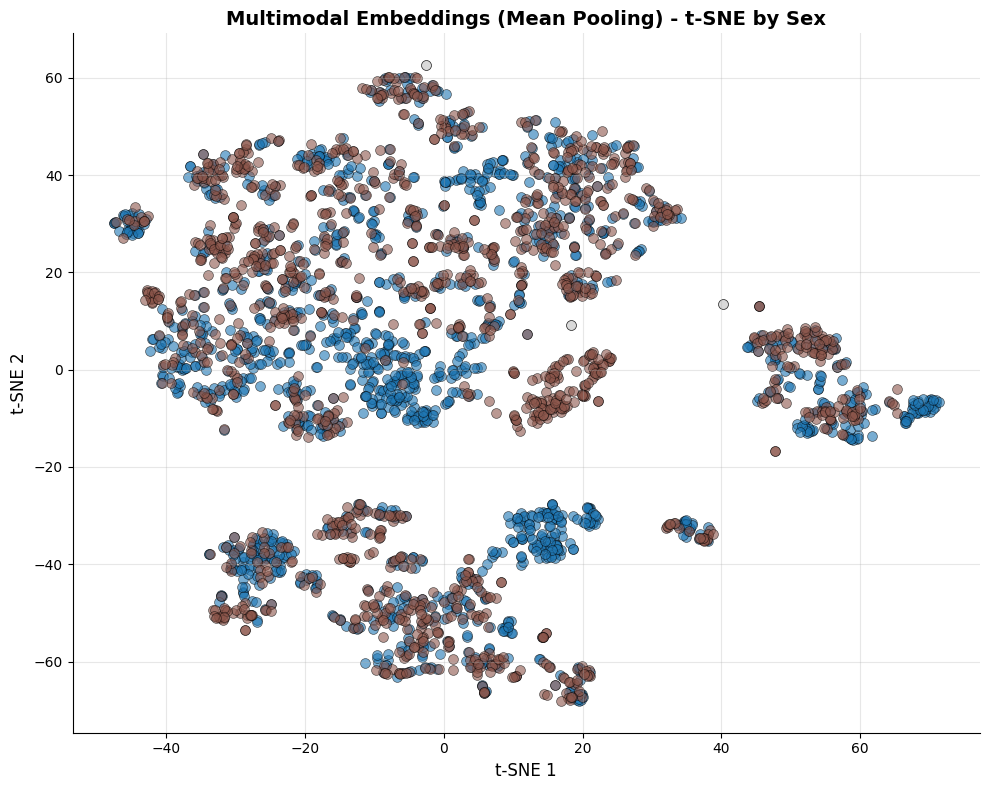

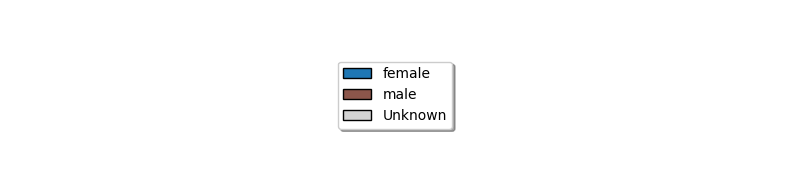


✅ Mean pooling fusion analysis complete!


In [21]:
if multimodal_results['mean_pool'] is not None:
    print("=" * 60)
    print("📊 MEAN POOLING FUSION ANALYSIS")
    print("=" * 60)
    
    # Mean pooling fusion
    mean_embeddings = multimodal_results['mean_pool']
    metadata = multimodal_results['metadata']
    
    print(f"\n📊 Mean pooled embeddings statistics:")
    print(f"  Shape: {mean_embeddings.shape}")
    print(f"  Memory usage: {mean_embeddings.nbytes / (1024**2):.2f} MB")
    print(f"  Dimension reduction: {concat_embeddings.shape[1] / mean_embeddings.shape[1]:.1f}x")
    
    # Visualize by cancer type
    print("\n🎨 Creating t-SNE visualization by cancer type...")
    labels = metadata['project_id'].values
    _ = create_tsne_visualization(
        mean_embeddings,
        labels,
        "Multimodal Embeddings (Mean Pooling) - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by sex
    print("\n👥 Creating t-SNE visualization by sex...")
    labels = metadata['gender'].values
    _ = create_tsne_visualization(
        mean_embeddings,
        labels,
        "Multimodal Embeddings (Mean Pooling) - t-SNE by Sex",
        sample_size=sample_size
    )
    
    print("\n✅ Mean pooling fusion analysis complete!")
else:
    print("❌ No multimodal mean pooling embeddings available")

### 6.4 Multimodal Fusion: Kronecker Product ⊗

The Kronecker product captures pairwise interactions between modalities, revealing synergistic patterns that simple concatenation might miss.

⊗ KRONECKER PRODUCT FUSION ANALYSIS

📊 Kronecker product embeddings statistics:
  Shape: (3000, 100)
  Memory usage: 1.14 MB
  Captures: Pairwise modality interactions

🎨 Creating t-SNE visualization by cancer type...
Computing t-SNE for 3000 samples...


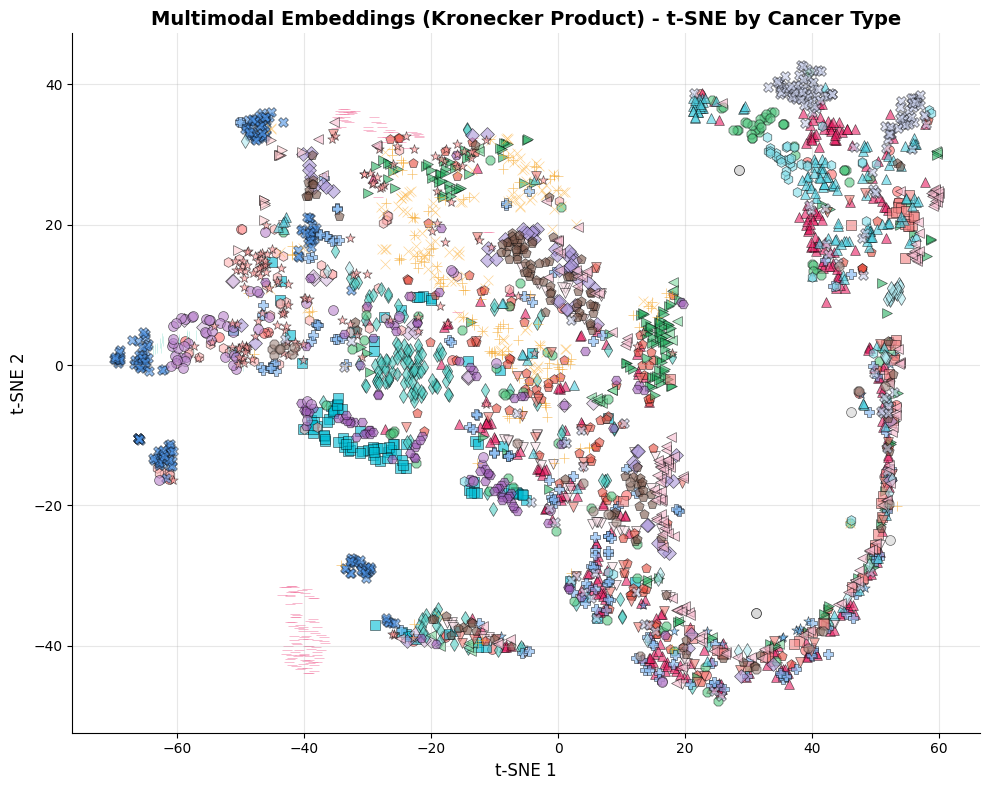

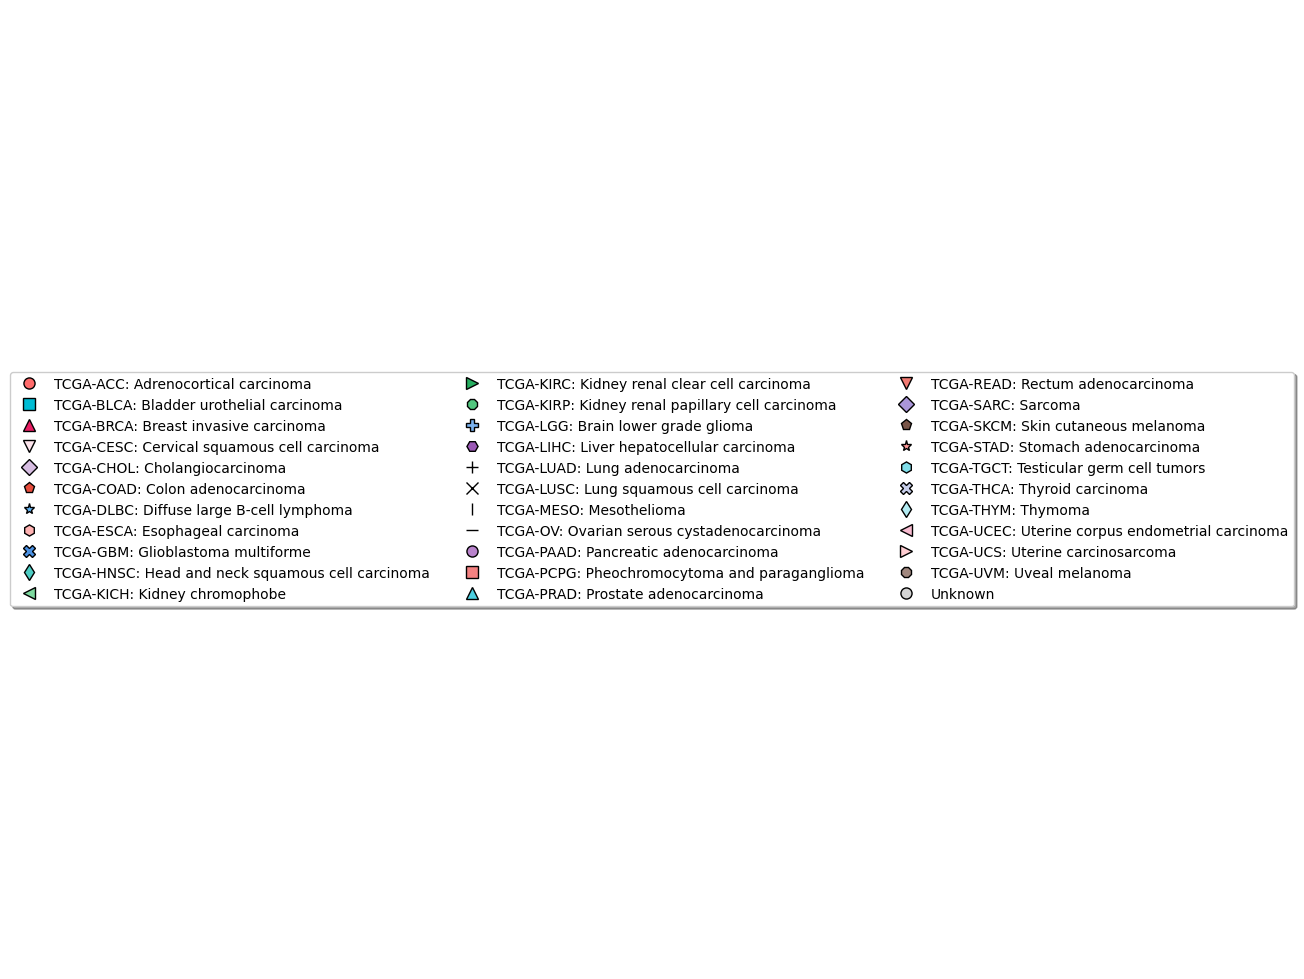


👥 Creating t-SNE visualization by age group...
Computing t-SNE for 3000 samples...


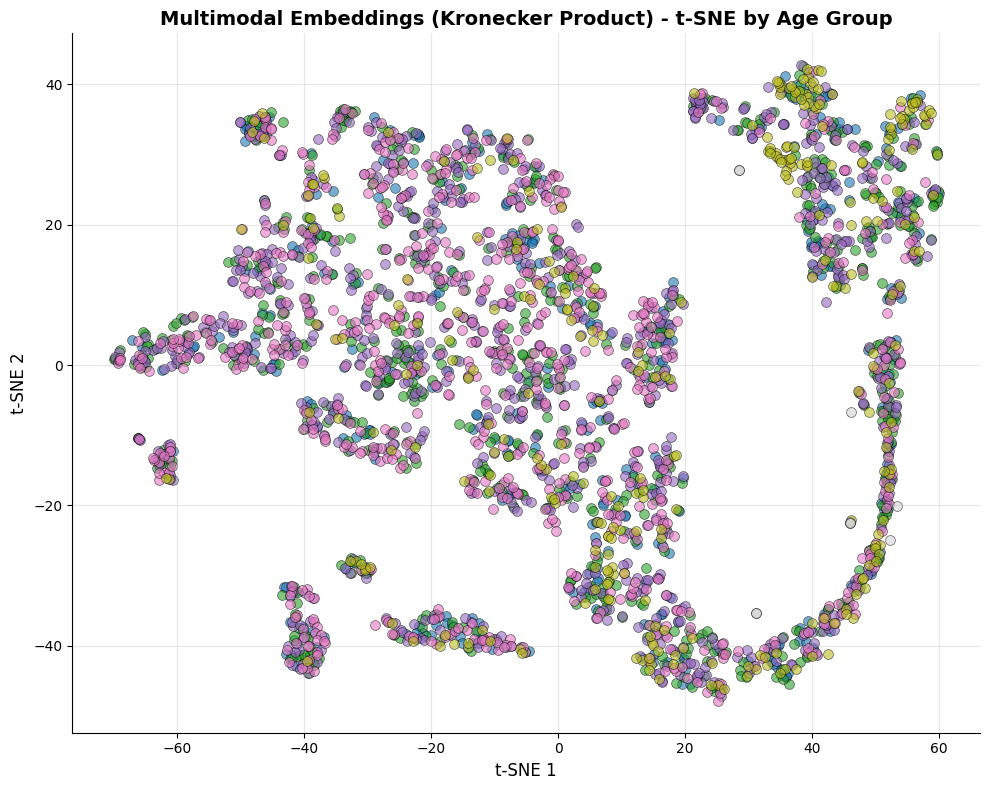

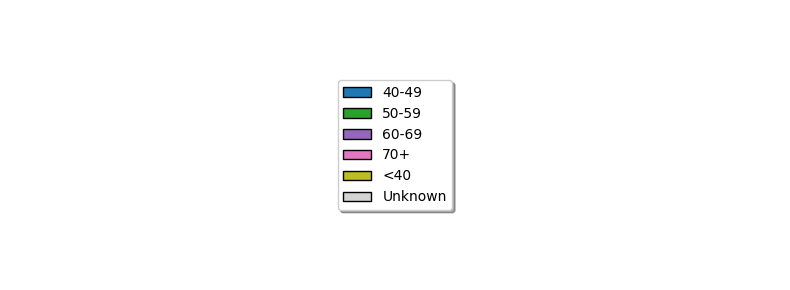


✅ Kronecker product fusion analysis complete!


In [22]:
if multimodal_results['kronecker'] is not None:
    print("=" * 60)
    print("⊗ KRONECKER PRODUCT FUSION ANALYSIS")
    print("=" * 60)
    
    # Kronecker product fusion
    kronecker_embeddings = multimodal_results['kronecker']
    metadata = multimodal_results['metadata']
    
    print(f"\n📊 Kronecker product embeddings statistics:")
    print(f"  Shape: {kronecker_embeddings.shape}")
    print(f"  Memory usage: {kronecker_embeddings.nbytes / (1024**2):.2f} MB")
    print(f"  Captures: Pairwise modality interactions")
    
    # Visualize by cancer type
    print("\n🎨 Creating t-SNE visualization by cancer type...")
    labels = metadata['project_id'].values
    _ = create_tsne_visualization(
        kronecker_embeddings,
        labels,
        "Multimodal Embeddings (Kronecker Product) - t-SNE by Cancer Type",
        sample_size=sample_size
    )
    
    # Visualize by age group
    print("\n👥 Creating t-SNE visualization by age group...")
    labels = metadata['age_group'].values
    _ = create_tsne_visualization(
        kronecker_embeddings,
        labels,
        "Multimodal Embeddings (Kronecker Product) - t-SNE by Age Group",
        sample_size=sample_size
    )
    
    print("\n✅ Kronecker product fusion analysis complete!")
else:
    print("❌ No multimodal Kronecker embeddings available")

## 7. Analysis and Discussion 💡

### 7.1 Understanding Multimodal Integration

Let's analyze the characteristics and trade-offs of each fusion method:

#### **Concatenation** 📎
- ✅ **Advantages**: Preserves all information from each modality
- ❌ **Disadvantages**: High dimensionality, curse of dimensionality
- 🎯 **Best for**: When modalities contain complementary, non-redundant information

#### **Mean Pooling** 📊
- ✅ **Advantages**: Compact representation, computationally efficient
- ❌ **Disadvantages**: Assumes equal importance, may lose modality-specific signals
- 🎯 **Best for**: When all modalities are equally informative

#### **Kronecker Product** ⊗
- ✅ **Advantages**: Captures cross-modal interactions, reveals synergistic patterns
- ❌ **Disadvantages**: Computationally intensive, limited to pairwise interactions
- 🎯 **Best for**: Discovering relationships between modalities

### 7.2 Key Observations from t-SNE Visualizations 🔍

#### **1. Cancer Type Clustering** 🧬
- Similar cancer types cluster together (e.g., kidney cancers KIRC, KIRP, KICH)
- Organ system relationships are preserved in the embedding space
- TCGA color scheme helps visualize cancer type families

#### **2. Modality-Specific Insights** 🔬
- **Clinical**: Captures patient demographics and disease characteristics
- **Pathology**: Rich histological and diagnostic information
- **Molecular**: Genetic signatures and expression patterns
- **WSI**: Visual tissue architecture features
- **Radiology**: Anatomical and functional imaging characteristics

#### **3. Multimodal Benefits** 🚀
- Improved cluster separation between cancer types
- Reveals disease subtypes within cancer categories
- More comprehensive patient representations
- Better capture of disease heterogeneity

### 7.3 Clinical Implications 🏥

The multimodal approach enables:
1. **Precision Medicine**: More accurate patient stratification
2. **Biomarker Discovery**: Cross-modal pattern identification
3. **Treatment Planning**: Comprehensive patient profiling
4. **Prognosis**: Better outcome prediction with integrated data

## 8. Comparison with Different Embedding Models 🔄

Let's explore how different state-of-the-art embedding models affect representation quality. Each model brings unique strengths to the analysis.

## 10. Save Embeddings for Future Use 💾

To enable seamless integration with subsequent notebooks (like classification), let's save all the embeddings and metadata we've generated.

## 📌 Summary and Next Steps

### What We've Accomplished
1. ✅ **Loaded multimodal TCGA embeddings** from HuggingFace with efficient caching
2. ✅ **Patient-level aggregation** for WSI and radiology data (multiple samples per patient)
3. ✅ **Created comprehensive t-SNE visualizations** for each modality
4. ✅ **Implemented multimodal fusion strategies** (concatenation, mean pooling, Kronecker product)
5. ✅ **Saved all embeddings** to persistent storage for downstream analyses

### Google Colab Optimizations
- 🚀 **Memory-efficient processing** with batch loading and garbage collection
- 💾 **Google Drive integration** for persistent storage across sessions
- 📊 **Smart caching** to avoid re-downloading large datasets
- 🎨 **Automatic visualization saving** to Drive

### Key Files Saved
- **Patient-level embeddings**: `{modality}_embeddings.npy` and `{modality}_metadata.pkl`
- **Patient mapping**: `patient_modality_map.pkl`
- **Multimodal results**: `multimodal_results.pkl`
- **Visualizations**: All t-SNE plots and legends in the outputs folder

### Next Steps
1. **Classification Analysis**: Use the saved embeddings for cancer type classification
2. **Survival Analysis**: Integrate with clinical outcomes data
3. **Biomarker Discovery**: Identify cross-modal patterns
4. **Custom Models**: Train your own embedding models on TCGA data

### Tips for Colab Users
- 🔄 **Resume work**: Your embeddings are saved in Drive - just remount and load!
- 📦 **Download results**: Use `files.download()` to get embeddings locally
- 🧹 **Memory management**: Restart runtime if you hit memory limits
- ⚡ **Faster loading**: Use the cached embeddings instead of re-extracting

### Resources
- 📚 [HoneyBee Documentation](https://github.com/lab-rasool/HoneyBee)
- 🤗 [TCGA Dataset on HuggingFace](https://huggingface.co/datasets/Lab-Rasool/TCGA)
- 📊 [Example Analyses](https://github.com/lab-rasool/HoneyBee/tree/main/examples)

In [23]:
print("=" * 60)
print("💾 SAVING PATIENT-LEVEL EMBEDDINGS FOR FUTURE USE")
print("=" * 60)

import pickle
from pathlib import Path
import json

# Create output directory based on environment
if 'IN_COLAB' in globals() and IN_COLAB:
    output_dir = Path(DRIVE_EMBEDDINGS_DIR) / "patient_level"
    print(f"\n📁 Using Google Drive for persistent storage: {output_dir}")
else:
    output_dir = Path("embedding_cache")
    print(f"\n📁 Using local directory: {output_dir}")

output_dir.mkdir(exist_ok=True, parents=True)

# Save individual modality embeddings - now using patient-level aggregated data
embeddings_to_save = {
    'clinical': (clinical_embeddings, clinical_metadata),
    'pathology': (pathology_embeddings, pathology_metadata),
    'wsi': (wsi_embeddings, wsi_metadata),  # Now patient-level aggregated
    'molecular': (molecular_embeddings, molecular_metadata),
    'radiology': (radiology_embeddings, radiology_metadata)  # Now patient-level aggregated
}

saved_count = 0
for modality, (embeddings, metadata) in embeddings_to_save.items():
    if embeddings is not None:
        # Save embeddings as numpy array
        np.save(output_dir / f"{modality}_embeddings.npy", embeddings)
        
        # Save metadata as pickle
        with open(output_dir / f"{modality}_metadata.pkl", 'wb') as f:
            pickle.dump(metadata, f)
        
        print(f"  ✓ Saved {modality}: {embeddings.shape}")
        saved_count += 1

# Save patient-modality mapping (updated with aggregated indices)
if 'patient_modality_map' in globals():
    with open(output_dir / "patient_modality_map.pkl", 'wb') as f:
        pickle.dump(patient_modality_map, f)
    print(f"  ✓ Saved patient-modality mapping: {len(patient_modality_map)} patients")

# Save multimodal results if available
if 'multimodal_results' in globals() and multimodal_results is not None:
    with open(output_dir / "multimodal_results.pkl", 'wb') as f:
        pickle.dump(multimodal_results, f)
    print(f"  ✓ Saved multimodal fusion results")

# Also save the original sample-level data for reference (if available)
if 'original_wsi_embeddings' in globals() and original_wsi_embeddings is not None:
    np.save(output_dir / "wsi_embeddings_sample_level.npy", original_wsi_embeddings)
    with open(output_dir / "wsi_metadata_sample_level.pkl", 'wb') as f:
        pickle.dump(original_wsi_metadata, f)
    print(f"  ✓ Saved original WSI sample-level data: {original_wsi_embeddings.shape}")

if 'original_radiology_embeddings' in globals() and original_radiology_embeddings is not None:
    np.save(output_dir / "radiology_embeddings_sample_level.npy", original_radiology_embeddings)
    with open(output_dir / "radiology_metadata_sample_level.pkl", 'wb') as f:
        pickle.dump(original_radiology_metadata, f)
    print(f"  ✓ Saved original radiology sample-level data: {original_radiology_embeddings.shape}")

# Save a summary file with information about the cache
summary = {
    'creation_date': pd.Timestamp.now().isoformat(),
    'modalities_saved': list(embeddings_to_save.keys()),
    'total_patients': len(patient_modality_map) if 'patient_modality_map' in globals() else 'Unknown',
    'patient_level_aggregation': {
        'wsi': 'mean_pooling_across_slides',
        'radiology': 'hierarchical_mean_pooling_scans_then_slices'
    },
    'embedding_shapes': {
        k: v[0].shape if v[0] is not None else None 
        for k, v in embeddings_to_save.items()
    },
    'sample_level_shapes': {
        'wsi': original_wsi_embeddings.shape if 'original_wsi_embeddings' in globals() and original_wsi_embeddings is not None else None,
        'radiology': original_radiology_embeddings.shape if 'original_radiology_embeddings' in globals() and original_radiology_embeddings is not None else None
    },
    'multimodal_available': 'multimodal_results' in globals()
}

with open(output_dir / "cache_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✅ Successfully saved {saved_count} modality embeddings (patient-level)!")
print(f"📂 Cache location: {output_dir.absolute()}")

# Special message for Colab users
if 'IN_COLAB' in globals() and IN_COLAB:
    print("\n🌟 For Google Colab users:")
    print("   Your embeddings are saved in Google Drive and will persist across sessions!")
    print(f"   Location: {output_dir}")
    print("\n   To download the embeddings locally, use:")
    print("   ```python")
    print("   from google.colab import files")
    print(f"   files.download('{output_dir}/clinical_embeddings.npy')")
    print("   ```")
else:
    print("\n💡 To load in another notebook:")
    print("   ```python")
    print("   import numpy as np")
    print("   import pickle")
    print("   ")
    print("   # Load patient-level embeddings")
    print("   clinical_embeddings = np.load('embedding_cache/clinical_embeddings.npy')")
    print("   with open('embedding_cache/clinical_metadata.pkl', 'rb') as f:")
    print("       clinical_metadata = pickle.load(f)")
    print("   ")
    print("   # WSI and radiology are now patient-level aggregated")
    print("   wsi_embeddings = np.load('embedding_cache/wsi_embeddings.npy')")
    print("   with open('embedding_cache/wsi_metadata.pkl', 'rb') as f:")
    print("       wsi_metadata = pickle.load(f)")
    print("   ```")

💾 SAVING PATIENT-LEVEL EMBEDDINGS FOR FUTURE USE

📁 Using local directory: embedding_cache
  ✓ Saved clinical: (10771, 1024)
  ✓ Saved pathology: (10857, 1024)
  ✓ Saved wsi: (8060, 1024)
  ✓ Saved molecular: (13804, 48)
  ✓ Saved radiology: (1149, 1000)
  ✓ Saved patient-modality mapping: 11145 patients
  ✓ Saved multimodal fusion results
  ✓ Saved original WSI sample-level data: (22643, 1024)
  ✓ Saved original radiology sample-level data: (11229, 1000)

✅ Successfully saved 5 modality embeddings (patient-level)!
📂 Cache location: /mnt/f/Projects/HoneyBee/examples/mayo/embedding_cache

💡 To load in another notebook:
   ```python
   import numpy as np
   import pickle
   
   # Load patient-level embeddings
   clinical_embeddings = np.load('embedding_cache/clinical_embeddings.npy')
   with open('embedding_cache/clinical_metadata.pkl', 'rb') as f:
       clinical_metadata = pickle.load(f)
   
   # WSI and radiology are now patient-level aggregated
   wsi_embeddings = np.load('embedding_